In [1]:
import torch
import torch.nn as nn
import modin.pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r"D:\PyTorch for Deep Learning with Python Bootcamp\1. Course Overview, Installs, and Setup\PYTORCH_NOTEBOOKS\Data\NYCTaxiFares.csv")

In [3]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  -----------------  ---------------  -----  
 0   pickup_datetime    120000 non-null  object
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3 MB


In [4]:
df['pickup_hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour

In [5]:
df['AM_or_PM'] = df.apply(lambda x: 'AM' if x['pickup_hour']<12 else 'PM', axis = 1)

In [6]:
def haversine_distance(lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(long2 -long1)
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    return d

In [7]:
df['distance_km'] = list(map(haversine_distance, df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'],df['dropoff_longitude']))

In [8]:
df['weekday'] = pd.DatetimeIndex(df['pickup_datetime']).weekday # 6 sun 0 mon

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,AM_or_PM,distance_km,weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,8,AM,2.126312,0
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,15,PM,1.392307,5
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,11,AM,3.326763,5
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,21,PM,1.864129,6
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2,AM,7.231321,5


In [10]:
for i in ['pickup_hour','AM_or_PM','weekday']:
    df[i] = df[i].astype('category')

In [11]:
df = df.drop(columns=['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'])

In [12]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype   
---  ---------------  ---------------  -----   
 0   fare_amount      120000 non-null  float64
 1   fare_class       120000 non-null  int64
 2   passenger_count  120000 non-null  int64
 3   pickup_hour      120000 non-null  category
 4   AM_or_PM         120000 non-null  category
 5   distance_km      120000 non-null  float64
 6   weekday          120000 non-null  category
dtypes: int64(2), float64(2), category(1), category(1), category(1)
memory usage: 4.0 MB


In [13]:
df['AM_or_PM'].cat.categories

To request implementation, send an email to feature_requests@modin.org.


Index(['AM', 'PM'], dtype='object')

In [14]:
df['weekday'].cat.codes

0         0
1         5
2         5
3         6
4         5
         ..
119995    6
119996    4
119997    6
119998    1
119999    5
Length: 120000, dtype: int8

In [64]:
df['weekday'].cat.categories

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

In [15]:
cat_c = np.stack([df[i].cat.codes.values for i in ['pickup_hour','AM_or_PM','weekday']], axis = 1)

In [66]:
cat_c

tensor([[ 8,  0,  0],
        [15,  1,  5],
        [11,  0,  5],
        ...,
        [18,  1,  6],
        [ 8,  0,  1],
        [16,  1,  5]])

In [16]:
conc_c = np.stack([df[i].values for i in ['fare_class','passenger_count','distance_km']], axis = 1)

In [68]:
conc_c.shape

torch.Size([120000, 3])

In [17]:
cat_c = torch.tensor(cat_c, dtype =torch.int64 )
conc_c = torch.tensor(conc_c, dtype =torch.float )
y = torch.tensor(df['fare_amount'].values, dtype = torch.float).reshape(-1,1)

In [18]:
y

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [19]:
conc_c.shape

torch.Size([120000, 3])

# Now One hot encode using torch embedding which is a lookup table containg key value pair where key is the category and value is the vector of dim n

In [20]:
cat_size = [len(df[i].cat.categories) for i in ['pickup_hour','AM_or_PM','weekday']]

In [21]:
9//2

4

In [22]:
9/2

4.5

In [23]:
embed_size = [(size, min(50, (size+1)//2)) for size in cat_size] # // rounds down 50 because we want vector of size 50 or less

In [24]:
embed_size

[(24, 12), (2, 1), (7, 4)]

In [25]:
selfembed = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in embed_size])

In [26]:
cat_c[4]

tensor([2, 0, 5])

In [27]:
test_cat_c = torch.tensor([[2,1,2]])
test_cat_c

tensor([[2, 1, 2]])

In [28]:
embedding = []
for i,e in enumerate(selfembed):
    embedding.append(e(test_cat_c[:,i]))

In [29]:
embedding

[tensor([[-1.1124,  0.2242,  0.6690,  1.1743, -2.6891,  0.3539, -1.0149, -1.0410,
           0.4637,  0.2157,  0.5359,  0.2581]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.6753]], grad_fn=<EmbeddingBackward>),
 tensor([[-0.6669,  0.8389, -0.5700,  0.1643]], grad_fn=<EmbeddingBackward>)]

In [30]:
embedding = []
for i,e in enumerate(selfembed):
    embedding.append(e(cat_c[4,i]))
embedding

[tensor([-1.1124,  0.2242,  0.6690,  1.1743, -2.6891,  0.3539, -1.0149, -1.0410,
          0.4637,  0.2157,  0.5359,  0.2581], grad_fn=<EmbeddingBackward>),
 tensor([-0.4573], grad_fn=<EmbeddingBackward>),
 tensor([ 0.1938, -1.1592,  1.3837, -0.2915], grad_fn=<EmbeddingBackward>)]

# from the above experiment we saw that the vector for 2 remains the same 

In [31]:
torch.cat(embedding)

tensor([-1.1124,  0.2242,  0.6690,  1.1743, -2.6891,  0.3539, -1.0149, -1.0410,
         0.4637,  0.2157,  0.5359,  0.2581, -0.4573,  0.1938, -1.1592,  1.3837,
        -0.2915], grad_fn=<CatBackward>)

# Setting up Tabular model

In [32]:
import torch.nn as nn

In [33]:
class TabularModel(nn.Module):
    
    def __init__(self, embed_size, n_cont, n_out, neuron_layer, prob = 0.5):
        super().__init__()
        self.embed = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in embed_size])
        self.embed_drop = nn.Dropout(prob)
        self.batchnorm_cont = nn.BatchNorm1d(n_cont)
        
        num_embed = sum([nf for ni,nf in embed_size])
        n_input = num_embed + n_cont
        
        layerlist = []
        for i in neuron_layer:
            layerlist.append(nn.Linear(n_input,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(prob))
            n_input = i
        layerlist.append(nn.Linear(neuron_layer[-1], n_out))
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embed):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, axis = 1)
        x = self.embed_drop(x)
        x_cont = self.batchnorm_cont(x_cont)
        x = torch.cat([x,x_cont],axis = 1)
        x = self.layers(x)
        return x
        

In [34]:
model = TabularModel(embed_size,conc_c.shape[1],1,[32,64,128])

In [35]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [36]:
train_size = 60000
test_size = int(train_size*0.2)

In [37]:
train_cat = cat_c[:train_size-test_size]
test_cat = cat_c[train_size-test_size:train_size]
train_cont = conc_c[:train_size-test_size]
test_cont = conc_c[train_size-test_size:train_size]
y_train = y[:train_size-test_size]
y_test = y[train_size-test_size:train_size]

In [38]:
train_cat.shape

torch.Size([48000, 3])

In [39]:
epochs = 300
losses = []

for i in range(epochs):
    i = i+1
    
    y_pred = model(train_cat, train_cont)
    loss = torch.sqrt(loss_func(y_pred, y_train))
    losses.append(loss)
    
    if i%10 == 0:
        print(f'Epoch {i} loss is {loss}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch 10 loss is 12.235721588134766
Epoch 20 loss is 11.811171531677246
Epoch 30 loss is 11.290786743164062
Epoch 40 loss is 10.833174705505371
Epoch 50 loss is 10.518258094787598
Epoch 60 loss is 10.260760307312012
Epoch 70 loss is 9.998199462890625
Epoch 80 loss is 9.735298156738281
Epoch 90 loss is 9.4154634475708
Epoch 100 loss is 9.005512237548828
Epoch 110 loss is 8.606677055358887
Epoch 120 loss is 8.09679889678955
Epoch 130 loss is 7.564262866973877
Epoch 140 loss is 7.030579090118408
Epoch 150 loss is 6.444336891174316
Epoch 160 loss is 5.910465240478516
Epoch 170 loss is 5.35580587387085
Epoch 180 loss is 4.926940441131592
Epoch 190 loss is 4.591641902923584
Epoch 200 loss is 4.386697769165039
Epoch 210 loss is 4.230413436889648
Epoch 220 loss is 4.201067924499512
Epoch 230 loss is 4.083415985107422
Epoch 240 loss is 4.0302414894104
Epoch 250 loss is 3.9263646602630615
Epoch 260 loss is 3.9106857776641846
Epoch 270 loss is 3.8714494705200195
Epoch 280 loss is 3.82167410850524

In [53]:
import matplotlib.pyplot as plt

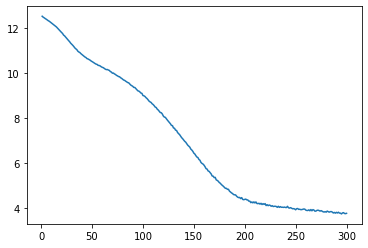

In [59]:
plt.plot(list(range(1,epochs+1)),losses)


# Model Evaluation on test data

In [45]:
with torch.no_grad():
    y_val = model(test_cat, test_cont)
    loss = torch.sqrt(loss_func(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.75334978


In [50]:
y_val[1]

tensor([11.4849])

In [52]:
for i in range(len(y_val)):
    print(f'The Original value is {y_test[i]} and the predicted value is {y_val[i]} and the difference is {np.abs(y_val[i]-y_test[i])}')

The Original value is tensor([2.9000]) and the predicted value is tensor([4.7457]) and the difference is tensor([1.8457])
The Original value is tensor([5.7000]) and the predicted value is tensor([11.4849]) and the difference is tensor([5.7849])
The Original value is tensor([7.7000]) and the predicted value is tensor([7.3336]) and the difference is tensor([0.3664])
The Original value is tensor([12.5000]) and the predicted value is tensor([11.9975]) and the difference is tensor([0.5025])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.1935]) and the difference is tensor([1.0935])
The Original value is tensor([5.3000]) and the predicted value is tensor([3.1044]) and the difference is tensor([2.1956])
The Original value is tensor([3.7000]) and the predicted value is tensor([-1.8115]) and the difference is tensor([5.5115])
The Original value is tensor([14.5000]) and the predicted value is tensor([23.7355]) and the difference is tensor([9.2355])
The Original value

The Original value is tensor([4.9000]) and the predicted value is tensor([6.6035]) and the difference is tensor([1.7035])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.1755]) and the difference is tensor([0.3245])
The Original value is tensor([10.5000]) and the predicted value is tensor([11.8844]) and the difference is tensor([1.3844])
The Original value is tensor([24.6700]) and the predicted value is tensor([17.7408]) and the difference is tensor([6.9292])
The Original value is tensor([7.3000]) and the predicted value is tensor([9.1910]) and the difference is tensor([1.8910])
The Original value is tensor([3.7000]) and the predicted value is tensor([3.8386]) and the difference is tensor([0.1386])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.6836]) and the difference is tensor([0.8164])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.8576]) and the difference is tensor([1.0424])
The Original value i

The Original value is tensor([4.1000]) and the predicted value is tensor([6.2626]) and the difference is tensor([2.1626])
The Original value is tensor([6.5000]) and the predicted value is tensor([7.0445]) and the difference is tensor([0.5445])
The Original value is tensor([6.5000]) and the predicted value is tensor([7.6934]) and the difference is tensor([1.1934])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.8221]) and the difference is tensor([0.0779])
The Original value is tensor([12.5000]) and the predicted value is tensor([15.6558]) and the difference is tensor([3.1558])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.9190]) and the difference is tensor([0.0190])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.2846]) and the difference is tensor([1.0154])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.5356]) and the difference is tensor([0.0356])
The Original value is 

The Original value is tensor([10.9000]) and the predicted value is tensor([15.3480]) and the difference is tensor([4.4480])
The Original value is tensor([8.5000]) and the predicted value is tensor([9.7413]) and the difference is tensor([1.2413])
The Original value is tensor([3.7000]) and the predicted value is tensor([6.0213]) and the difference is tensor([2.3213])
The Original value is tensor([4.5000]) and the predicted value is tensor([3.3126]) and the difference is tensor([1.1874])
The Original value is tensor([12.9000]) and the predicted value is tensor([10.8311]) and the difference is tensor([2.0689])
The Original value is tensor([22.1000]) and the predicted value is tensor([36.4301]) and the difference is tensor([14.3301])
The Original value is tensor([6.5000]) and the predicted value is tensor([3.3496]) and the difference is tensor([3.1504])
The Original value is tensor([10.9000]) and the predicted value is tensor([11.7544]) and the difference is tensor([0.8544])
The Original va

The Original value is tensor([30.1000]) and the predicted value is tensor([22.7810]) and the difference is tensor([7.3190])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.5635]) and the difference is tensor([1.2635])
The Original value is tensor([21.3000]) and the predicted value is tensor([13.2137]) and the difference is tensor([8.0863])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.1072]) and the difference is tensor([2.1928])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.8145]) and the difference is tensor([0.0855])
The Original value is tensor([10.1000]) and the predicted value is tensor([15.0964]) and the difference is tensor([4.9964])
The Original value is tensor([14.1000]) and the predicted value is tensor([11.0127]) and the difference is tensor([3.0873])
The Original value is tensor([3.3000]) and the predicted value is tensor([3.2091]) and the difference is tensor([0.0909])
The Original val

The Original value is tensor([9.3000]) and the predicted value is tensor([9.6301]) and the difference is tensor([0.3301])
The Original value is tensor([16.5000]) and the predicted value is tensor([18.3264]) and the difference is tensor([1.8264])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.4731]) and the difference is tensor([1.9731])
The Original value is tensor([7.3000]) and the predicted value is tensor([4.0258]) and the difference is tensor([3.2742])
The Original value is tensor([8.9000]) and the predicted value is tensor([6.6181]) and the difference is tensor([2.2819])
The Original value is tensor([12.1000]) and the predicted value is tensor([9.9543]) and the difference is tensor([2.1457])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.4545]) and the difference is tensor([0.0455])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.8625]) and the difference is tensor([0.9625])
The Original value is

The Original value is tensor([5.3000]) and the predicted value is tensor([7.2216]) and the difference is tensor([1.9216])
The Original value is tensor([11.7000]) and the predicted value is tensor([10.2689]) and the difference is tensor([1.4311])
The Original value is tensor([10.1000]) and the predicted value is tensor([13.4084]) and the difference is tensor([3.3084])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.8597]) and the difference is tensor([1.1597])
The Original value is tensor([7.3000]) and the predicted value is tensor([8.7910]) and the difference is tensor([1.4910])
The Original value is tensor([4.1000]) and the predicted value is tensor([4.7525]) and the difference is tensor([0.6525])
The Original value is tensor([6.1000]) and the predicted value is tensor([4.4755]) and the difference is tensor([1.6245])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.4775]) and the difference is tensor([1.8225])
The Original value i

The Original value is tensor([8.1000]) and the predicted value is tensor([9.8049]) and the difference is tensor([1.7049])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.8971]) and the difference is tensor([0.0029])
The Original value is tensor([7.7000]) and the predicted value is tensor([4.8735]) and the difference is tensor([2.8265])
The Original value is tensor([6.1000]) and the predicted value is tensor([7.1775]) and the difference is tensor([1.0775])
The Original value is tensor([14.9000]) and the predicted value is tensor([17.6151]) and the difference is tensor([2.7151])
The Original value is tensor([5.3000]) and the predicted value is tensor([2.0494]) and the difference is tensor([3.2506])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.5476]) and the difference is tensor([0.8476])
The Original value is tensor([16.5000]) and the predicted value is tensor([14.1967]) and the difference is tensor([2.3033])
The Original value i

The Original value is tensor([18.9000]) and the predicted value is tensor([15.2778]) and the difference is tensor([3.6222])
The Original value is tensor([5.3000]) and the predicted value is tensor([7.6668]) and the difference is tensor([2.3668])
The Original value is tensor([9.7000]) and the predicted value is tensor([7.1241]) and the difference is tensor([2.5759])
The Original value is tensor([8.5000]) and the predicted value is tensor([9.1677]) and the difference is tensor([0.6677])
The Original value is tensor([10.1000]) and the predicted value is tensor([8.0188]) and the difference is tensor([2.0812])
The Original value is tensor([10.1000]) and the predicted value is tensor([14.1125]) and the difference is tensor([4.0125])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.9227]) and the difference is tensor([0.4227])
The Original value is tensor([6.5000]) and the predicted value is tensor([7.1171]) and the difference is tensor([0.6171])
The Original value 

The Original value is tensor([10.9000]) and the predicted value is tensor([19.7178]) and the difference is tensor([8.8178])
The Original value is tensor([10.5000]) and the predicted value is tensor([13.1187]) and the difference is tensor([2.6187])
The Original value is tensor([4.9000]) and the predicted value is tensor([10.3719]) and the difference is tensor([5.4719])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.9459]) and the difference is tensor([1.7541])
The Original value is tensor([36.9900]) and the predicted value is tensor([39.6132]) and the difference is tensor([2.6232])
The Original value is tensor([12.1000]) and the predicted value is tensor([15.2338]) and the difference is tensor([3.1338])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.6703]) and the difference is tensor([0.3703])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.5563]) and the difference is tensor([0.3437])
The Original va

The Original value is tensor([3.3000]) and the predicted value is tensor([6.9546]) and the difference is tensor([3.6546])
The Original value is tensor([17.7000]) and the predicted value is tensor([21.8062]) and the difference is tensor([4.1062])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.8607]) and the difference is tensor([0.9607])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.6661]) and the difference is tensor([0.8339])
The Original value is tensor([20.9000]) and the predicted value is tensor([17.2745]) and the difference is tensor([3.6255])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.5232]) and the difference is tensor([0.5768])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.2825]) and the difference is tensor([0.1825])
The Original value is tensor([11.3000]) and the predicted value is tensor([11.7084]) and the difference is tensor([0.4084])
The Original value

The Original value is tensor([8.9000]) and the predicted value is tensor([6.8592]) and the difference is tensor([2.0408])
The Original value is tensor([3.7000]) and the predicted value is tensor([4.1455]) and the difference is tensor([0.4455])
The Original value is tensor([10.1000]) and the predicted value is tensor([10.6650]) and the difference is tensor([0.5650])
The Original value is tensor([10.9000]) and the predicted value is tensor([13.6992]) and the difference is tensor([2.7992])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.4004]) and the difference is tensor([2.2996])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.5194]) and the difference is tensor([0.8194])
The Original value is tensor([12.5000]) and the predicted value is tensor([16.6884]) and the difference is tensor([4.1884])
The Original value is tensor([5.3000]) and the predicted value is tensor([3.9591]) and the difference is tensor([1.3409])
The Original value

The Original value is tensor([15.3000]) and the predicted value is tensor([12.9043]) and the difference is tensor([2.3957])
The Original value is tensor([7.7000]) and the predicted value is tensor([4.8401]) and the difference is tensor([2.8599])
The Original value is tensor([3.7000]) and the predicted value is tensor([5.7352]) and the difference is tensor([2.0352])
The Original value is tensor([4.9000]) and the predicted value is tensor([3.8819]) and the difference is tensor([1.0181])
The Original value is tensor([4.9000]) and the predicted value is tensor([4.4626]) and the difference is tensor([0.4374])
The Original value is tensor([49.5700]) and the predicted value is tensor([35.7121]) and the difference is tensor([13.8579])
The Original value is tensor([8.1000]) and the predicted value is tensor([8.6147]) and the difference is tensor([0.5147])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.6664]) and the difference is tensor([0.7664])
The Original value 

The Original value is tensor([12.9000]) and the predicted value is tensor([10.9183]) and the difference is tensor([1.9817])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.9577]) and the difference is tensor([0.1423])
The Original value is tensor([7.3000]) and the predicted value is tensor([4.5219]) and the difference is tensor([2.7781])
The Original value is tensor([16.1000]) and the predicted value is tensor([16.6848]) and the difference is tensor([0.5848])
The Original value is tensor([10.5000]) and the predicted value is tensor([11.6449]) and the difference is tensor([1.1449])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.8234]) and the difference is tensor([0.2766])
The Original value is tensor([6.1000]) and the predicted value is tensor([8.0255]) and the difference is tensor([1.9255])
The Original value is tensor([9.7000]) and the predicted value is tensor([10.4926]) and the difference is tensor([0.7926])
The Original valu

The Original value is tensor([6.9000]) and the predicted value is tensor([4.1642]) and the difference is tensor([2.7358])
The Original value is tensor([4.1000]) and the predicted value is tensor([4.7987]) and the difference is tensor([0.6987])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.2765]) and the difference is tensor([0.0235])
The Original value is tensor([6.5000]) and the predicted value is tensor([8.3448]) and the difference is tensor([1.8448])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.1714]) and the difference is tensor([1.9286])
The Original value is tensor([12.9000]) and the predicted value is tensor([12.3684]) and the difference is tensor([0.5316])
The Original value is tensor([6.1000]) and the predicted value is tensor([3.4820]) and the difference is tensor([2.6180])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.4120]) and the difference is tensor([0.8880])
The Original value is 

The Original value is tensor([14.1000]) and the predicted value is tensor([19.9823]) and the difference is tensor([5.8823])
The Original value is tensor([29.6000]) and the predicted value is tensor([38.1475]) and the difference is tensor([8.5475])
The Original value is tensor([7.3000]) and the predicted value is tensor([3.1294]) and the difference is tensor([4.1706])
The Original value is tensor([11.3000]) and the predicted value is tensor([15.1001]) and the difference is tensor([3.8001])
The Original value is tensor([16.5000]) and the predicted value is tensor([21.8990]) and the difference is tensor([5.3990])
The Original value is tensor([4.5000]) and the predicted value is tensor([3.9434]) and the difference is tensor([0.5566])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.7842]) and the difference is tensor([1.0842])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.1988]) and the difference is tensor([0.2988])
The Original val

The Original value is tensor([11.7000]) and the predicted value is tensor([11.7250]) and the difference is tensor([0.0251])
The Original value is tensor([4.5000]) and the predicted value is tensor([3.8198]) and the difference is tensor([0.6802])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.7652]) and the difference is tensor([1.5348])
The Original value is tensor([5.7000]) and the predicted value is tensor([4.5226]) and the difference is tensor([1.1774])
The Original value is tensor([4.1000]) and the predicted value is tensor([2.8673]) and the difference is tensor([1.2327])
The Original value is tensor([9.3000]) and the predicted value is tensor([8.9831]) and the difference is tensor([0.3169])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.8548]) and the difference is tensor([0.9548])
The Original value is tensor([14.5000]) and the predicted value is tensor([18.4214]) and the difference is tensor([3.9214])
The Original value i

The Original value is tensor([8.5000]) and the predicted value is tensor([5.9840]) and the difference is tensor([2.5160])
The Original value is tensor([49.5700]) and the predicted value is tensor([29.0180]) and the difference is tensor([20.5520])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.9025]) and the difference is tensor([1.2025])
The Original value is tensor([15.3000]) and the predicted value is tensor([14.1227]) and the difference is tensor([1.1773])
The Original value is tensor([8.5000]) and the predicted value is tensor([11.9299]) and the difference is tensor([3.4299])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.8260]) and the difference is tensor([0.2740])
The Original value is tensor([3.7000]) and the predicted value is tensor([9.1098]) and the difference is tensor([5.4098])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.2804]) and the difference is tensor([1.6196])
The Original value

The Original value is tensor([8.9000]) and the predicted value is tensor([5.1285]) and the difference is tensor([3.7715])
The Original value is tensor([10.1000]) and the predicted value is tensor([12.8010]) and the difference is tensor([2.7010])
The Original value is tensor([18.9000]) and the predicted value is tensor([12.9560]) and the difference is tensor([5.9440])
The Original value is tensor([14.9000]) and the predicted value is tensor([15.0105]) and the difference is tensor([0.1105])
The Original value is tensor([12.9000]) and the predicted value is tensor([7.9376]) and the difference is tensor([4.9624])
The Original value is tensor([15.3000]) and the predicted value is tensor([16.8810]) and the difference is tensor([1.5810])
The Original value is tensor([17.7000]) and the predicted value is tensor([14.6108]) and the difference is tensor([3.0892])
The Original value is tensor([17.7000]) and the predicted value is tensor([18.2440]) and the difference is tensor([0.5440])
The Origina

The Original value is tensor([10.1000]) and the predicted value is tensor([11.1704]) and the difference is tensor([1.0704])
The Original value is tensor([7.7000]) and the predicted value is tensor([9.4940]) and the difference is tensor([1.7940])
The Original value is tensor([24.9000]) and the predicted value is tensor([23.6206]) and the difference is tensor([1.2794])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.7119]) and the difference is tensor([0.8119])
The Original value is tensor([6.5000]) and the predicted value is tensor([8.1811]) and the difference is tensor([1.6811])
The Original value is tensor([8.9000]) and the predicted value is tensor([6.9430]) and the difference is tensor([1.9570])
The Original value is tensor([4.1000]) and the predicted value is tensor([7.8035]) and the difference is tensor([3.7035])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.3944]) and the difference is tensor([1.0944])
The Original value i

The Original value is tensor([32.6700]) and the predicted value is tensor([33.1084]) and the difference is tensor([0.4384])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.4142]) and the difference is tensor([2.2858])
The Original value is tensor([6.9000]) and the predicted value is tensor([8.1456]) and the difference is tensor([1.2456])
The Original value is tensor([5.3000]) and the predicted value is tensor([2.9603]) and the difference is tensor([2.3397])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.4693]) and the difference is tensor([1.3693])
The Original value is tensor([8.1000]) and the predicted value is tensor([4.6977]) and the difference is tensor([3.4023])
The Original value is tensor([10.5000]) and the predicted value is tensor([17.2940]) and the difference is tensor([6.7940])
The Original value is tensor([12.9000]) and the predicted value is tensor([11.3595]) and the difference is tensor([1.5405])
The Original value

The Original value is tensor([6.1000]) and the predicted value is tensor([5.8444]) and the difference is tensor([0.2556])
The Original value is tensor([6.1000]) and the predicted value is tensor([2.2538]) and the difference is tensor([3.8462])
The Original value is tensor([18.1000]) and the predicted value is tensor([17.0142]) and the difference is tensor([1.0858])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.7974]) and the difference is tensor([0.5026])
The Original value is tensor([4.9000]) and the predicted value is tensor([6.6041]) and the difference is tensor([1.7041])
The Original value is tensor([6.9000]) and the predicted value is tensor([4.8327]) and the difference is tensor([2.0673])
The Original value is tensor([11.3000]) and the predicted value is tensor([12.2232]) and the difference is tensor([0.9232])
The Original value is tensor([4.1000]) and the predicted value is tensor([6.2554]) and the difference is tensor([2.1554])
The Original value i

The Original value is tensor([11.7000]) and the predicted value is tensor([13.3317]) and the difference is tensor([1.6317])
The Original value is tensor([8.9000]) and the predicted value is tensor([6.9527]) and the difference is tensor([1.9473])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.2934]) and the difference is tensor([1.7934])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.0056]) and the difference is tensor([0.1056])
The Original value is tensor([4.9000]) and the predicted value is tensor([7.0582]) and the difference is tensor([2.1582])
The Original value is tensor([3.3000]) and the predicted value is tensor([2.4101]) and the difference is tensor([0.8899])
The Original value is tensor([11.3000]) and the predicted value is tensor([13.4650]) and the difference is tensor([2.1650])
The Original value is tensor([6.1000]) and the predicted value is tensor([7.8772]) and the difference is tensor([1.7772])
The Original value i

The Original value is tensor([4.9000]) and the predicted value is tensor([8.6055]) and the difference is tensor([3.7055])
The Original value is tensor([20.9000]) and the predicted value is tensor([9.4083]) and the difference is tensor([11.4917])
The Original value is tensor([4.1000]) and the predicted value is tensor([6.7571]) and the difference is tensor([2.6571])
The Original value is tensor([10.5000]) and the predicted value is tensor([11.6318]) and the difference is tensor([1.1318])
The Original value is tensor([18.1000]) and the predicted value is tensor([18.9040]) and the difference is tensor([0.8040])
The Original value is tensor([31.3000]) and the predicted value is tensor([28.9100]) and the difference is tensor([2.3900])
The Original value is tensor([4.9000]) and the predicted value is tensor([7.0002]) and the difference is tensor([2.1002])
The Original value is tensor([8.5000]) and the predicted value is tensor([9.8145]) and the difference is tensor([1.3145])
The Original val

The Original value is tensor([10.1000]) and the predicted value is tensor([10.4446]) and the difference is tensor([0.3446])
The Original value is tensor([11.7000]) and the predicted value is tensor([12.7491]) and the difference is tensor([1.0491])
The Original value is tensor([6.9000]) and the predicted value is tensor([8.2692]) and the difference is tensor([1.3692])
The Original value is tensor([3.7000]) and the predicted value is tensor([9.2729]) and the difference is tensor([5.5729])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.0360]) and the difference is tensor([0.4640])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.7725]) and the difference is tensor([1.4725])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.7685]) and the difference is tensor([0.1315])
The Original value is tensor([15.7000]) and the predicted value is tensor([17.1905]) and the difference is tensor([1.4905])
The Original value

The Original value is tensor([4.5000]) and the predicted value is tensor([4.4674]) and the difference is tensor([0.0326])
The Original value is tensor([8.5000]) and the predicted value is tensor([9.2887]) and the difference is tensor([0.7887])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.0245]) and the difference is tensor([1.4755])
The Original value is tensor([9.3000]) and the predicted value is tensor([8.2564]) and the difference is tensor([1.0436])
The Original value is tensor([11.3000]) and the predicted value is tensor([10.8080]) and the difference is tensor([0.4920])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.9490]) and the difference is tensor([0.3510])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.3487]) and the difference is tensor([0.6487])
The Original value is tensor([36.1000]) and the predicted value is tensor([33.9513]) and the difference is tensor([2.1487])
The Original value i

The Original value is tensor([27.8700]) and the predicted value is tensor([24.2247]) and the difference is tensor([3.6453])
The Original value is tensor([12.1000]) and the predicted value is tensor([16.5412]) and the difference is tensor([4.4412])
The Original value is tensor([11.3000]) and the predicted value is tensor([12.3495]) and the difference is tensor([1.0495])
The Original value is tensor([9.3000]) and the predicted value is tensor([5.8407]) and the difference is tensor([3.4593])
The Original value is tensor([9.7000]) and the predicted value is tensor([10.0653]) and the difference is tensor([0.3653])
The Original value is tensor([10.1000]) and the predicted value is tensor([12.9587]) and the difference is tensor([2.8587])
The Original value is tensor([4.1000]) and the predicted value is tensor([4.7396]) and the difference is tensor([0.6396])
The Original value is tensor([28.5000]) and the predicted value is tensor([27.0854]) and the difference is tensor([1.4146])
The Original 

The Original value is tensor([11.3000]) and the predicted value is tensor([11.8571]) and the difference is tensor([0.5571])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.9543]) and the difference is tensor([0.8543])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.6698]) and the difference is tensor([0.4302])
The Original value is tensor([20.9000]) and the predicted value is tensor([20.7992]) and the difference is tensor([0.1008])
The Original value is tensor([8.5000]) and the predicted value is tensor([5.3107]) and the difference is tensor([3.1893])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.3865]) and the difference is tensor([0.3135])
The Original value is tensor([9.7000]) and the predicted value is tensor([4.0299]) and the difference is tensor([5.6701])
The Original value is tensor([8.9000]) and the predicted value is tensor([8.3235]) and the difference is tensor([0.5765])
The Original value i

The Original value is tensor([7.7000]) and the predicted value is tensor([6.2470]) and the difference is tensor([1.4530])
The Original value is tensor([7.3000]) and the predicted value is tensor([2.4802]) and the difference is tensor([4.8198])
The Original value is tensor([13.3000]) and the predicted value is tensor([11.8708]) and the difference is tensor([1.4292])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.6193]) and the difference is tensor([1.6807])
The Original value is tensor([11.7000]) and the predicted value is tensor([11.3224]) and the difference is tensor([0.3776])
The Original value is tensor([8.9000]) and the predicted value is tensor([5.4856]) and the difference is tensor([3.4144])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.8268]) and the difference is tensor([2.3268])
The Original value is tensor([6.5000]) and the predicted value is tensor([5.7977]) and the difference is tensor([0.7023])
The Original value i

The Original value is tensor([10.9000]) and the predicted value is tensor([10.1288]) and the difference is tensor([0.7712])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.7806]) and the difference is tensor([0.3194])
The Original value is tensor([10.1000]) and the predicted value is tensor([15.4791]) and the difference is tensor([5.3791])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.2798]) and the difference is tensor([1.7798])
The Original value is tensor([6.9000]) and the predicted value is tensor([2.7544]) and the difference is tensor([4.1456])
The Original value is tensor([28.1000]) and the predicted value is tensor([23.8594]) and the difference is tensor([4.2406])
The Original value is tensor([6.1000]) and the predicted value is tensor([4.1231]) and the difference is tensor([1.9769])
The Original value is tensor([9.7000]) and the predicted value is tensor([7.9289]) and the difference is tensor([1.7711])
The Original value

The Original value is tensor([4.9000]) and the predicted value is tensor([6.5228]) and the difference is tensor([1.6228])
The Original value is tensor([10.9000]) and the predicted value is tensor([15.3291]) and the difference is tensor([4.4291])
The Original value is tensor([19.3000]) and the predicted value is tensor([13.1775]) and the difference is tensor([6.1225])
The Original value is tensor([4.9000]) and the predicted value is tensor([2.6679]) and the difference is tensor([2.2321])
The Original value is tensor([17.7000]) and the predicted value is tensor([12.2742]) and the difference is tensor([5.4258])
The Original value is tensor([8.5000]) and the predicted value is tensor([4.8816]) and the difference is tensor([3.6184])
The Original value is tensor([3.3000]) and the predicted value is tensor([4.7912]) and the difference is tensor([1.4912])
The Original value is tensor([7.3000]) and the predicted value is tensor([4.9519]) and the difference is tensor([2.3481])
The Original value

The Original value is tensor([4.1000]) and the predicted value is tensor([6.6012]) and the difference is tensor([2.5012])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.3455]) and the difference is tensor([0.6455])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.7966]) and the difference is tensor([1.1034])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.4086]) and the difference is tensor([0.8914])
The Original value is tensor([4.9000]) and the predicted value is tensor([9.0842]) and the difference is tensor([4.1842])
The Original value is tensor([13.3000]) and the predicted value is tensor([12.4529]) and the difference is tensor([0.8471])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.6501]) and the difference is tensor([1.2499])
The Original value is tensor([10.1000]) and the predicted value is tensor([11.9638]) and the difference is tensor([1.8638])
The Original value i

The Original value is tensor([5.7000]) and the predicted value is tensor([7.5333]) and the difference is tensor([1.8333])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.9220]) and the difference is tensor([0.0220])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.2360]) and the difference is tensor([0.2640])
The Original value is tensor([9.3000]) and the predicted value is tensor([7.1082]) and the difference is tensor([2.1918])
The Original value is tensor([10.9000]) and the predicted value is tensor([8.4306]) and the difference is tensor([2.4694])
The Original value is tensor([6.9000]) and the predicted value is tensor([4.9117]) and the difference is tensor([1.9883])
The Original value is tensor([4.9000]) and the predicted value is tensor([7.6774]) and the difference is tensor([2.7774])
The Original value is tensor([8.9000]) and the predicted value is tensor([8.3845]) and the difference is tensor([0.5155])
The Original value is t

The Original value is tensor([10.1000]) and the predicted value is tensor([13.6080]) and the difference is tensor([3.5080])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.7549]) and the difference is tensor([1.1451])
The Original value is tensor([10.1000]) and the predicted value is tensor([11.6649]) and the difference is tensor([1.5649])
The Original value is tensor([9.7000]) and the predicted value is tensor([9.4559]) and the difference is tensor([0.2441])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.3733]) and the difference is tensor([0.2733])
The Original value is tensor([10.5000]) and the predicted value is tensor([9.8829]) and the difference is tensor([0.6171])
The Original value is tensor([7.7000]) and the predicted value is tensor([4.8151]) and the difference is tensor([2.8849])
The Original value is tensor([33.7000]) and the predicted value is tensor([31.0087]) and the difference is tensor([2.6913])
The Original valu

The Original value is tensor([9.7000]) and the predicted value is tensor([6.0675]) and the difference is tensor([3.6325])
The Original value is tensor([11.7000]) and the predicted value is tensor([8.5839]) and the difference is tensor([3.1161])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.4394]) and the difference is tensor([1.3394])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.2017]) and the difference is tensor([1.2983])
The Original value is tensor([12.1000]) and the predicted value is tensor([11.9389]) and the difference is tensor([0.1611])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.8405]) and the difference is tensor([1.0595])
The Original value is tensor([6.9000]) and the predicted value is tensor([4.1853]) and the difference is tensor([2.7147])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.7267]) and the difference is tensor([0.2267])
The Original value is

The Original value is tensor([4.1000]) and the predicted value is tensor([0.8219]) and the difference is tensor([3.2781])
The Original value is tensor([4.1000]) and the predicted value is tensor([3.9763]) and the difference is tensor([0.1237])
The Original value is tensor([22.1000]) and the predicted value is tensor([9.8571]) and the difference is tensor([12.2429])
The Original value is tensor([4.5000]) and the predicted value is tensor([3.0232]) and the difference is tensor([1.4768])
The Original value is tensor([10.1000]) and the predicted value is tensor([15.5428]) and the difference is tensor([5.4428])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.2732]) and the difference is tensor([0.9732])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.8627]) and the difference is tensor([0.7627])
The Original value is tensor([12.1000]) and the predicted value is tensor([16.4631]) and the difference is tensor([4.3631])
The Original value

The Original value is tensor([10.9000]) and the predicted value is tensor([13.7805]) and the difference is tensor([2.8805])
The Original value is tensor([10.9000]) and the predicted value is tensor([10.7862]) and the difference is tensor([0.1138])
The Original value is tensor([5.3000]) and the predicted value is tensor([1.6889]) and the difference is tensor([3.6111])
The Original value is tensor([25.6000]) and the predicted value is tensor([16.0348]) and the difference is tensor([9.5652])
The Original value is tensor([6.9000]) and the predicted value is tensor([8.7525]) and the difference is tensor([1.8525])
The Original value is tensor([4.5000]) and the predicted value is tensor([5.1994]) and the difference is tensor([0.6994])
The Original value is tensor([3.7000]) and the predicted value is tensor([5.6322]) and the difference is tensor([1.9322])
The Original value is tensor([9.3000]) and the predicted value is tensor([8.9045]) and the difference is tensor([0.3955])
The Original value

The Original value is tensor([12.1000]) and the predicted value is tensor([13.5361]) and the difference is tensor([1.4361])
The Original value is tensor([20.1000]) and the predicted value is tensor([19.7780]) and the difference is tensor([0.3220])
The Original value is tensor([14.1000]) and the predicted value is tensor([16.1184]) and the difference is tensor([2.0184])
The Original value is tensor([13.7000]) and the predicted value is tensor([14.8971]) and the difference is tensor([1.1971])
The Original value is tensor([9.7000]) and the predicted value is tensor([11.6384]) and the difference is tensor([1.9384])
The Original value is tensor([8.9000]) and the predicted value is tensor([8.0018]) and the difference is tensor([0.8982])
The Original value is tensor([4.9000]) and the predicted value is tensor([7.0835]) and the difference is tensor([2.1835])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.0870]) and the difference is tensor([0.2130])
The Original va

The Original value is tensor([7.3000]) and the predicted value is tensor([7.2696]) and the difference is tensor([0.0304])
The Original value is tensor([10.1000]) and the predicted value is tensor([10.6425]) and the difference is tensor([0.5425])
The Original value is tensor([12.5000]) and the predicted value is tensor([9.4184]) and the difference is tensor([3.0816])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.6960]) and the difference is tensor([1.4040])
The Original value is tensor([4.9000]) and the predicted value is tensor([6.4791]) and the difference is tensor([1.5791])
The Original value is tensor([7.7000]) and the predicted value is tensor([10.2721]) and the difference is tensor([2.5721])
The Original value is tensor([5.7000]) and the predicted value is tensor([1.9455]) and the difference is tensor([3.7545])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.3476]) and the difference is tensor([0.9524])
The Original value i

The Original value is tensor([8.9000]) and the predicted value is tensor([7.3181]) and the difference is tensor([1.5819])
The Original value is tensor([8.1000]) and the predicted value is tensor([8.4664]) and the difference is tensor([0.3664])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.4798]) and the difference is tensor([1.4202])
The Original value is tensor([23.4700]) and the predicted value is tensor([14.1034]) and the difference is tensor([9.3666])
The Original value is tensor([3.3000]) and the predicted value is tensor([3.4561]) and the difference is tensor([0.1561])
The Original value is tensor([9.3000]) and the predicted value is tensor([9.5917]) and the difference is tensor([0.2917])
The Original value is tensor([14.5000]) and the predicted value is tensor([12.0164]) and the difference is tensor([2.4836])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.8546]) and the difference is tensor([0.4454])
The Original value i

The Original value is tensor([8.9000]) and the predicted value is tensor([5.2336]) and the difference is tensor([3.6664])
The Original value is tensor([15.3000]) and the predicted value is tensor([12.8495]) and the difference is tensor([2.4505])
The Original value is tensor([6.5000]) and the predicted value is tensor([8.0078]) and the difference is tensor([1.5078])
The Original value is tensor([4.5000]) and the predicted value is tensor([3.4708]) and the difference is tensor([1.0292])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.0174]) and the difference is tensor([0.2826])
The Original value is tensor([11.3000]) and the predicted value is tensor([14.0799]) and the difference is tensor([2.7799])
The Original value is tensor([4.1000]) and the predicted value is tensor([6.4269]) and the difference is tensor([2.3269])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.4197]) and the difference is tensor([0.2803])
The Original value i

The Original value is tensor([12.9000]) and the predicted value is tensor([10.2035]) and the difference is tensor([2.6965])
The Original value is tensor([8.1000]) and the predicted value is tensor([8.2732]) and the difference is tensor([0.1732])
The Original value is tensor([16.1000]) and the predicted value is tensor([14.7807]) and the difference is tensor([1.3193])
The Original value is tensor([6.1000]) and the predicted value is tensor([8.2207]) and the difference is tensor([2.1207])
The Original value is tensor([11.3000]) and the predicted value is tensor([13.3980]) and the difference is tensor([2.0980])
The Original value is tensor([9.3000]) and the predicted value is tensor([9.7040]) and the difference is tensor([0.4040])
The Original value is tensor([12.9000]) and the predicted value is tensor([15.4903]) and the difference is tensor([2.5903])
The Original value is tensor([27.7000]) and the predicted value is tensor([22.5751]) and the difference is tensor([5.1249])
The Original v

The Original value is tensor([6.5000]) and the predicted value is tensor([8.2566]) and the difference is tensor([1.7566])
The Original value is tensor([10.1000]) and the predicted value is tensor([13.4757]) and the difference is tensor([3.3757])
The Original value is tensor([49.5700]) and the predicted value is tensor([68.6717]) and the difference is tensor([19.1017])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.5704]) and the difference is tensor([0.7296])
The Original value is tensor([8.9000]) and the predicted value is tensor([7.9259]) and the difference is tensor([0.9741])
The Original value is tensor([6.1000]) and the predicted value is tensor([7.6125]) and the difference is tensor([1.5125])
The Original value is tensor([10.5000]) and the predicted value is tensor([14.6026]) and the difference is tensor([4.1026])
The Original value is tensor([11.3000]) and the predicted value is tensor([12.8772]) and the difference is tensor([1.5772])
The Original va

The Original value is tensor([2.5000]) and the predicted value is tensor([2.7886]) and the difference is tensor([0.2886])
The Original value is tensor([18.1000]) and the predicted value is tensor([22.0524]) and the difference is tensor([3.9524])
The Original value is tensor([4.9000]) and the predicted value is tensor([7.0198]) and the difference is tensor([2.1198])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.3146]) and the difference is tensor([0.0146])
The Original value is tensor([24.9000]) and the predicted value is tensor([25.4801]) and the difference is tensor([0.5801])
The Original value is tensor([13.7000]) and the predicted value is tensor([19.5218]) and the difference is tensor([5.8218])
The Original value is tensor([10.9000]) and the predicted value is tensor([13.5460]) and the difference is tensor([2.6460])
The Original value is tensor([12.1000]) and the predicted value is tensor([9.7367]) and the difference is tensor([2.3633])
The Original va

The Original value is tensor([10.1000]) and the predicted value is tensor([11.8118]) and the difference is tensor([1.7118])
The Original value is tensor([9.7000]) and the predicted value is tensor([8.0402]) and the difference is tensor([1.6598])
The Original value is tensor([10.9000]) and the predicted value is tensor([12.7114]) and the difference is tensor([1.8114])
The Original value is tensor([9.3000]) and the predicted value is tensor([6.9174]) and the difference is tensor([2.3826])
The Original value is tensor([9.7000]) and the predicted value is tensor([6.4714]) and the difference is tensor([3.2286])
The Original value is tensor([5.3000]) and the predicted value is tensor([7.4455]) and the difference is tensor([2.1455])
The Original value is tensor([4.5000]) and the predicted value is tensor([5.8359]) and the difference is tensor([1.3359])
The Original value is tensor([3.7000]) and the predicted value is tensor([2.2173]) and the difference is tensor([1.4827])
The Original value i

The Original value is tensor([3.7000]) and the predicted value is tensor([4.7236]) and the difference is tensor([1.0236])
The Original value is tensor([4.9000]) and the predicted value is tensor([4.7373]) and the difference is tensor([0.1627])
The Original value is tensor([11.7000]) and the predicted value is tensor([12.6663]) and the difference is tensor([0.9663])
The Original value is tensor([3.7000]) and the predicted value is tensor([2.9316]) and the difference is tensor([0.7684])
The Original value is tensor([7.3000]) and the predicted value is tensor([8.8806]) and the difference is tensor([1.5806])
The Original value is tensor([4.9000]) and the predicted value is tensor([3.8569]) and the difference is tensor([1.0431])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.2028]) and the difference is tensor([2.0972])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.5615]) and the difference is tensor([0.1385])
The Original value is 

The Original value is tensor([9.3000]) and the predicted value is tensor([7.3992]) and the difference is tensor([1.9008])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.4578]) and the difference is tensor([0.7578])
The Original value is tensor([9.7000]) and the predicted value is tensor([6.1198]) and the difference is tensor([3.5802])
The Original value is tensor([8.5000]) and the predicted value is tensor([5.4330]) and the difference is tensor([3.0670])
The Original value is tensor([24.1000]) and the predicted value is tensor([17.6470]) and the difference is tensor([6.4530])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.2682]) and the difference is tensor([0.3682])
The Original value is tensor([10.1000]) and the predicted value is tensor([12.5380]) and the difference is tensor([2.4380])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.8112]) and the difference is tensor([0.2888])
The Original value i

The Original value is tensor([8.9000]) and the predicted value is tensor([3.5224]) and the difference is tensor([5.3776])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.3754]) and the difference is tensor([0.4754])
The Original value is tensor([14.9000]) and the predicted value is tensor([15.7246]) and the difference is tensor([0.8246])
The Original value is tensor([4.5000]) and the predicted value is tensor([5.4652]) and the difference is tensor([0.9652])
The Original value is tensor([3.7000]) and the predicted value is tensor([2.7100]) and the difference is tensor([0.9900])
The Original value is tensor([4.1000]) and the predicted value is tensor([3.4951]) and the difference is tensor([0.6049])
The Original value is tensor([10.5000]) and the predicted value is tensor([8.9614]) and the difference is tensor([1.5386])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.5781]) and the difference is tensor([1.5219])
The Original value is

The Original value is tensor([4.9000]) and the predicted value is tensor([4.0933]) and the difference is tensor([0.8067])
The Original value is tensor([9.7000]) and the predicted value is tensor([7.9945]) and the difference is tensor([1.7055])
The Original value is tensor([8.5000]) and the predicted value is tensor([6.0770]) and the difference is tensor([2.4230])
The Original value is tensor([8.1000]) and the predicted value is tensor([8.0182]) and the difference is tensor([0.0818])
The Original value is tensor([7.3000]) and the predicted value is tensor([4.6198]) and the difference is tensor([2.6802])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.8815]) and the difference is tensor([1.5815])
The Original value is tensor([32.9000]) and the predicted value is tensor([11.2992]) and the difference is tensor([21.6008])
The Original value is tensor([7.7000]) and the predicted value is tensor([3.3418]) and the difference is tensor([4.3582])
The Original value is

The Original value is tensor([8.5000]) and the predicted value is tensor([9.6201]) and the difference is tensor([1.1201])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.9940]) and the difference is tensor([1.1060])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.4234]) and the difference is tensor([0.3234])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.7984]) and the difference is tensor([0.5016])
The Original value is tensor([5.7000]) and the predicted value is tensor([9.1691]) and the difference is tensor([3.4691])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.5362]) and the difference is tensor([1.3638])
The Original value is tensor([11.3000]) and the predicted value is tensor([14.9671]) and the difference is tensor([3.6671])
The Original value is tensor([30.9000]) and the predicted value is tensor([31.9906]) and the difference is tensor([1.0906])
The Original value i

The Original value is tensor([10.9000]) and the predicted value is tensor([11.5772]) and the difference is tensor([0.6772])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.7817]) and the difference is tensor([1.9183])
The Original value is tensor([9.3000]) and the predicted value is tensor([9.5610]) and the difference is tensor([0.2610])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.9782]) and the difference is tensor([0.9218])
The Original value is tensor([12.1000]) and the predicted value is tensor([9.4600]) and the difference is tensor([2.6400])
The Original value is tensor([13.7000]) and the predicted value is tensor([9.7854]) and the difference is tensor([3.9146])
The Original value is tensor([4.9000]) and the predicted value is tensor([7.6655]) and the difference is tensor([2.7655])
The Original value is tensor([5.7000]) and the predicted value is tensor([3.2627]) and the difference is tensor([2.4373])
The Original value i

The Original value is tensor([3.3000]) and the predicted value is tensor([4.0432]) and the difference is tensor([0.7432])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.3803]) and the difference is tensor([1.2803])
The Original value is tensor([10.5000]) and the predicted value is tensor([14.7640]) and the difference is tensor([4.2640])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.7258]) and the difference is tensor([1.9742])
The Original value is tensor([49.5700]) and the predicted value is tensor([33.2632]) and the difference is tensor([16.3068])
The Original value is tensor([8.9000]) and the predicted value is tensor([5.1151]) and the difference is tensor([3.7849])
The Original value is tensor([10.1000]) and the predicted value is tensor([12.8691]) and the difference is tensor([2.7691])
The Original value is tensor([7.3000]) and the predicted value is tensor([7.7702]) and the difference is tensor([0.4702])
The Original valu

The Original value is tensor([5.3000]) and the predicted value is tensor([0.1923]) and the difference is tensor([5.1077])
The Original value is tensor([7.7000]) and the predicted value is tensor([7.1077]) and the difference is tensor([0.5923])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.1719]) and the difference is tensor([0.0719])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.5168]) and the difference is tensor([0.0168])
The Original value is tensor([9.3000]) and the predicted value is tensor([7.1583]) and the difference is tensor([2.1417])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.3453]) and the difference is tensor([0.5547])
The Original value is tensor([12.9000]) and the predicted value is tensor([12.7282]) and the difference is tensor([0.1718])
The Original value is tensor([10.1000]) and the predicted value is tensor([11.9443]) and the difference is tensor([1.8443])
The Original value i

The Original value is tensor([4.9000]) and the predicted value is tensor([5.2777]) and the difference is tensor([0.3777])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.9334]) and the difference is tensor([0.6334])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.7067]) and the difference is tensor([0.3933])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.0555]) and the difference is tensor([0.4445])
The Original value is tensor([12.5000]) and the predicted value is tensor([9.4465]) and the difference is tensor([3.0535])
The Original value is tensor([13.3000]) and the predicted value is tensor([12.6359]) and the difference is tensor([0.6641])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.4026]) and the difference is tensor([0.8974])
The Original value is tensor([6.5000]) and the predicted value is tensor([7.6806]) and the difference is tensor([1.1806])
The Original value is

The Original value is tensor([14.5000]) and the predicted value is tensor([13.6578]) and the difference is tensor([0.8422])
The Original value is tensor([10.9000]) and the predicted value is tensor([17.2608]) and the difference is tensor([6.3608])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.9132]) and the difference is tensor([1.7868])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.0019]) and the difference is tensor([0.9019])
The Original value is tensor([14.9000]) and the predicted value is tensor([23.6290]) and the difference is tensor([8.7290])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.5862]) and the difference is tensor([1.7138])
The Original value is tensor([3.7000]) and the predicted value is tensor([5.9399]) and the difference is tensor([2.2399])
The Original value is tensor([4.5000]) and the predicted value is tensor([8.5436]) and the difference is tensor([4.0436])
The Original value

The Original value is tensor([8.5000]) and the predicted value is tensor([5.9589]) and the difference is tensor([2.5411])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.2971]) and the difference is tensor([0.5971])
The Original value is tensor([8.9000]) and the predicted value is tensor([10.1186]) and the difference is tensor([1.2186])
The Original value is tensor([5.3000]) and the predicted value is tensor([7.0358]) and the difference is tensor([1.7358])
The Original value is tensor([8.5000]) and the predicted value is tensor([9.2522]) and the difference is tensor([0.7522])
The Original value is tensor([14.1000]) and the predicted value is tensor([10.9496]) and the difference is tensor([3.1504])
The Original value is tensor([4.9000]) and the predicted value is tensor([6.9818]) and the difference is tensor([2.0818])
The Original value is tensor([19.3000]) and the predicted value is tensor([6.8123]) and the difference is tensor([12.4877])
The Original value 

The Original value is tensor([20.9000]) and the predicted value is tensor([27.6011]) and the difference is tensor([6.7011])
The Original value is tensor([2.9000]) and the predicted value is tensor([8.3214]) and the difference is tensor([5.4214])
The Original value is tensor([8.5000]) and the predicted value is tensor([4.6398]) and the difference is tensor([3.8602])
The Original value is tensor([11.3000]) and the predicted value is tensor([12.3445]) and the difference is tensor([1.0445])
The Original value is tensor([8.1000]) and the predicted value is tensor([5.8910]) and the difference is tensor([2.2090])
The Original value is tensor([12.9000]) and the predicted value is tensor([10.5336]) and the difference is tensor([2.3664])
The Original value is tensor([14.1000]) and the predicted value is tensor([19.7910]) and the difference is tensor([5.6910])
The Original value is tensor([12.9000]) and the predicted value is tensor([12.9705]) and the difference is tensor([0.0705])
The Original v

The Original value is tensor([6.1000]) and the predicted value is tensor([2.5400]) and the difference is tensor([3.5600])
The Original value is tensor([14.5000]) and the predicted value is tensor([10.3605]) and the difference is tensor([4.1395])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.6427]) and the difference is tensor([0.5427])
The Original value is tensor([4.9000]) and the predicted value is tensor([6.1210]) and the difference is tensor([1.2210])
The Original value is tensor([6.1000]) and the predicted value is tensor([3.6347]) and the difference is tensor([2.4653])
The Original value is tensor([18.9000]) and the predicted value is tensor([26.5712]) and the difference is tensor([7.6712])
The Original value is tensor([21.7000]) and the predicted value is tensor([23.2862]) and the difference is tensor([1.5862])
The Original value is tensor([15.3000]) and the predicted value is tensor([27.0162]) and the difference is tensor([11.7162])
The Original va

The Original value is tensor([4.5000]) and the predicted value is tensor([5.8600]) and the difference is tensor([1.3600])
The Original value is tensor([5.7000]) and the predicted value is tensor([2.6317]) and the difference is tensor([3.0683])
The Original value is tensor([12.1000]) and the predicted value is tensor([14.9495]) and the difference is tensor([2.8495])
The Original value is tensor([11.7000]) and the predicted value is tensor([13.7233]) and the difference is tensor([2.0233])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.2397]) and the difference is tensor([0.8603])
The Original value is tensor([14.9000]) and the predicted value is tensor([11.5843]) and the difference is tensor([3.3157])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.3183]) and the difference is tensor([1.9817])
The Original value is tensor([11.7000]) and the predicted value is tensor([11.9968]) and the difference is tensor([0.2968])
The Original val

The Original value is tensor([11.7000]) and the predicted value is tensor([10.5149]) and the difference is tensor([1.1851])
The Original value is tensor([15.8700]) and the predicted value is tensor([13.5392]) and the difference is tensor([2.3308])
The Original value is tensor([6.1000]) and the predicted value is tensor([7.2104]) and the difference is tensor([1.1104])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.0470]) and the difference is tensor([1.8530])
The Original value is tensor([16.9000]) and the predicted value is tensor([12.1732]) and the difference is tensor([4.7268])
The Original value is tensor([6.5000]) and the predicted value is tensor([3.2298]) and the difference is tensor([3.2702])
The Original value is tensor([15.7000]) and the predicted value is tensor([17.1881]) and the difference is tensor([1.4881])
The Original value is tensor([12.1000]) and the predicted value is tensor([16.7086]) and the difference is tensor([4.6086])
The Original v

The Original value is tensor([17.7000]) and the predicted value is tensor([18.8274]) and the difference is tensor([1.1274])
The Original value is tensor([13.7000]) and the predicted value is tensor([8.8351]) and the difference is tensor([4.8649])
The Original value is tensor([26.9000]) and the predicted value is tensor([19.0662]) and the difference is tensor([7.8338])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.7516]) and the difference is tensor([0.8516])
The Original value is tensor([3.3000]) and the predicted value is tensor([3.9508]) and the difference is tensor([0.6508])
The Original value is tensor([10.1000]) and the predicted value is tensor([13.6311]) and the difference is tensor([3.5311])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.5654]) and the difference is tensor([0.7346])
The Original value is tensor([4.9000]) and the predicted value is tensor([0.4075]) and the difference is tensor([4.4925])
The Original valu

The Original value is tensor([24.5000]) and the predicted value is tensor([25.5445]) and the difference is tensor([1.0445])
The Original value is tensor([8.5000]) and the predicted value is tensor([8.2573]) and the difference is tensor([0.2427])
The Original value is tensor([10.1000]) and the predicted value is tensor([7.5561]) and the difference is tensor([2.5440])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.3350]) and the difference is tensor([0.4350])
The Original value is tensor([29.7000]) and the predicted value is tensor([24.6648]) and the difference is tensor([5.0352])
The Original value is tensor([15.7000]) and the predicted value is tensor([13.1465]) and the difference is tensor([2.5535])
The Original value is tensor([12.5000]) and the predicted value is tensor([14.1584]) and the difference is tensor([1.6584])
The Original value is tensor([6.5000]) and the predicted value is tensor([7.2728]) and the difference is tensor([0.7728])
The Original va

The Original value is tensor([20.5000]) and the predicted value is tensor([18.5424]) and the difference is tensor([1.9576])
The Original value is tensor([10.1000]) and the predicted value is tensor([11.4482]) and the difference is tensor([1.3482])
The Original value is tensor([10.5000]) and the predicted value is tensor([12.8485]) and the difference is tensor([2.3485])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.8381]) and the difference is tensor([0.1381])
The Original value is tensor([8.9000]) and the predicted value is tensor([7.6133]) and the difference is tensor([1.2867])
The Original value is tensor([10.9000]) and the predicted value is tensor([11.2865]) and the difference is tensor([0.3865])
The Original value is tensor([10.9000]) and the predicted value is tensor([11.8603]) and the difference is tensor([0.9603])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.5865]) and the difference is tensor([0.0865])
The Original v

The Original value is tensor([5.3000]) and the predicted value is tensor([6.9959]) and the difference is tensor([1.6959])
The Original value is tensor([12.5000]) and the predicted value is tensor([11.5111]) and the difference is tensor([0.9889])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.9679]) and the difference is tensor([0.1321])
The Original value is tensor([6.5000]) and the predicted value is tensor([4.2655]) and the difference is tensor([2.2345])
The Original value is tensor([12.5000]) and the predicted value is tensor([10.7410]) and the difference is tensor([1.7590])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.9220]) and the difference is tensor([1.8220])
The Original value is tensor([7.7000]) and the predicted value is tensor([6.2783]) and the difference is tensor([1.4217])
The Original value is tensor([23.7000]) and the predicted value is tensor([21.5346]) and the difference is tensor([2.1654])
The Original value

The Original value is tensor([6.5000]) and the predicted value is tensor([6.2851]) and the difference is tensor([0.2149])
The Original value is tensor([11.3000]) and the predicted value is tensor([8.1096]) and the difference is tensor([3.1904])
The Original value is tensor([18.1000]) and the predicted value is tensor([22.2374]) and the difference is tensor([4.1374])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.5863]) and the difference is tensor([0.1137])
The Original value is tensor([8.5000]) and the predicted value is tensor([5.1959]) and the difference is tensor([3.3041])
The Original value is tensor([4.1000]) and the predicted value is tensor([3.9538]) and the difference is tensor([0.1462])
The Original value is tensor([6.9000]) and the predicted value is tensor([4.6042]) and the difference is tensor([2.2958])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.3668]) and the difference is tensor([1.7332])
The Original value is

The Original value is tensor([23.8700]) and the predicted value is tensor([16.3142]) and the difference is tensor([7.5558])
The Original value is tensor([6.5000]) and the predicted value is tensor([5.3684]) and the difference is tensor([1.1316])
The Original value is tensor([5.3000]) and the predicted value is tensor([7.7559]) and the difference is tensor([2.4559])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.3616]) and the difference is tensor([0.4616])
The Original value is tensor([16.1000]) and the predicted value is tensor([13.6737]) and the difference is tensor([2.4263])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.9942]) and the difference is tensor([0.9058])
The Original value is tensor([4.9000]) and the predicted value is tensor([3.8093]) and the difference is tensor([1.0907])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.1766]) and the difference is tensor([0.2766])
The Original value i

The Original value is tensor([8.1000]) and the predicted value is tensor([8.1769]) and the difference is tensor([0.0769])
The Original value is tensor([5.7000]) and the predicted value is tensor([8.4595]) and the difference is tensor([2.7595])
The Original value is tensor([7.7000]) and the predicted value is tensor([7.3520]) and the difference is tensor([0.3480])
The Original value is tensor([5.7000]) and the predicted value is tensor([4.0778]) and the difference is tensor([1.6222])
The Original value is tensor([6.9000]) and the predicted value is tensor([4.9984]) and the difference is tensor([1.9016])
The Original value is tensor([10.1000]) and the predicted value is tensor([11.6363]) and the difference is tensor([1.5363])
The Original value is tensor([8.9000]) and the predicted value is tensor([6.5921]) and the difference is tensor([2.3079])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.2368]) and the difference is tensor([0.0632])
The Original value is 

The Original value is tensor([4.1000]) and the predicted value is tensor([4.9887]) and the difference is tensor([0.8887])
The Original value is tensor([9.7000]) and the predicted value is tensor([6.9250]) and the difference is tensor([2.7750])
The Original value is tensor([3.3000]) and the predicted value is tensor([5.0791]) and the difference is tensor([1.7791])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.0260]) and the difference is tensor([0.8740])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.6776]) and the difference is tensor([0.1776])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.6930]) and the difference is tensor([0.7930])
The Original value is tensor([8.1000]) and the predicted value is tensor([9.3542]) and the difference is tensor([1.2542])
The Original value is tensor([6.9000]) and the predicted value is tensor([4.7574]) and the difference is tensor([2.1426])
The Original value is te

The Original value is tensor([7.3000]) and the predicted value is tensor([7.0220]) and the difference is tensor([0.2780])
The Original value is tensor([7.3000]) and the predicted value is tensor([3.7428]) and the difference is tensor([3.5572])
The Original value is tensor([8.5000]) and the predicted value is tensor([5.9646]) and the difference is tensor([2.5354])
The Original value is tensor([9.7000]) and the predicted value is tensor([8.8878]) and the difference is tensor([0.8122])
The Original value is tensor([25.3000]) and the predicted value is tensor([12.7369]) and the difference is tensor([12.5631])
The Original value is tensor([10.1000]) and the predicted value is tensor([10.7666]) and the difference is tensor([0.6666])
The Original value is tensor([11.7000]) and the predicted value is tensor([10.6439]) and the difference is tensor([1.0561])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.4781]) and the difference is tensor([0.5781])
The Original valu

The Original value is tensor([14.1000]) and the predicted value is tensor([10.0358]) and the difference is tensor([4.0642])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.1892]) and the difference is tensor([2.1108])
The Original value is tensor([16.9000]) and the predicted value is tensor([16.6801]) and the difference is tensor([0.2199])
The Original value is tensor([6.1000]) and the predicted value is tensor([8.0178]) and the difference is tensor([1.9178])
The Original value is tensor([6.9000]) and the predicted value is tensor([10.3148]) and the difference is tensor([3.4148])
The Original value is tensor([11.7000]) and the predicted value is tensor([7.7918]) and the difference is tensor([3.9082])
The Original value is tensor([5.7000]) and the predicted value is tensor([8.0790]) and the difference is tensor([2.3790])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.4285]) and the difference is tensor([1.8715])
The Original value

The Original value is tensor([9.7000]) and the predicted value is tensor([7.8846]) and the difference is tensor([1.8154])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.0411]) and the difference is tensor([1.0589])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.3691]) and the difference is tensor([1.5309])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.3829]) and the difference is tensor([1.8829])
The Original value is tensor([6.1000]) and the predicted value is tensor([1.9248]) and the difference is tensor([4.1752])
The Original value is tensor([6.1000]) and the predicted value is tensor([8.1374]) and the difference is tensor([2.0374])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.2918]) and the difference is tensor([0.6082])
The Original value is tensor([11.3000]) and the predicted value is tensor([13.1612]) and the difference is tensor([1.8612])
The Original value is 

The Original value is tensor([6.5000]) and the predicted value is tensor([7.7913]) and the difference is tensor([1.2913])
The Original value is tensor([7.7000]) and the predicted value is tensor([9.3032]) and the difference is tensor([1.6032])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.3112]) and the difference is tensor([1.7888])
The Original value is tensor([17.7000]) and the predicted value is tensor([23.1993]) and the difference is tensor([5.4993])
The Original value is tensor([11.3000]) and the predicted value is tensor([16.7309]) and the difference is tensor([5.4309])
The Original value is tensor([11.7000]) and the predicted value is tensor([12.2282]) and the difference is tensor([0.5282])
The Original value is tensor([13.7000]) and the predicted value is tensor([12.9181]) and the difference is tensor([0.7819])
The Original value is tensor([5.7000]) and the predicted value is tensor([4.7915]) and the difference is tensor([0.9085])
The Original val

The Original value is tensor([10.5000]) and the predicted value is tensor([10.6468]) and the difference is tensor([0.1468])
The Original value is tensor([18.1000]) and the predicted value is tensor([22.1408]) and the difference is tensor([4.0408])
The Original value is tensor([4.9000]) and the predicted value is tensor([4.5298]) and the difference is tensor([0.3702])
The Original value is tensor([4.5000]) and the predicted value is tensor([7.2699]) and the difference is tensor([2.7699])
The Original value is tensor([14.9000]) and the predicted value is tensor([16.4728]) and the difference is tensor([1.5728])
The Original value is tensor([28.2700]) and the predicted value is tensor([23.9190]) and the difference is tensor([4.3510])
The Original value is tensor([12.1000]) and the predicted value is tensor([13.3318]) and the difference is tensor([1.2318])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.3717]) and the difference is tensor([1.0717])
The Original v

The Original value is tensor([13.7000]) and the predicted value is tensor([12.5686]) and the difference is tensor([1.1314])
The Original value is tensor([12.9000]) and the predicted value is tensor([11.3359]) and the difference is tensor([1.5641])
The Original value is tensor([6.5000]) and the predicted value is tensor([0.9071]) and the difference is tensor([5.5929])
The Original value is tensor([4.9000]) and the predicted value is tensor([1.8019]) and the difference is tensor([3.0981])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.2740]) and the difference is tensor([0.0260])
The Original value is tensor([7.3000]) and the predicted value is tensor([8.2314]) and the difference is tensor([0.9314])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.1830]) and the difference is tensor([0.7170])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.3683]) and the difference is tensor([0.2683])
The Original value i

The Original value is tensor([4.5000]) and the predicted value is tensor([10.0360]) and the difference is tensor([5.5360])
The Original value is tensor([8.1000]) and the predicted value is tensor([11.0340]) and the difference is tensor([2.9340])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.8703]) and the difference is tensor([0.6297])
The Original value is tensor([18.9000]) and the predicted value is tensor([20.4991]) and the difference is tensor([1.5991])
The Original value is tensor([8.5000]) and the predicted value is tensor([4.2672]) and the difference is tensor([4.2328])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.7970]) and the difference is tensor([1.5030])
The Original value is tensor([8.1000]) and the predicted value is tensor([5.2407]) and the difference is tensor([2.8593])
The Original value is tensor([6.9000]) and the predicted value is tensor([4.9953]) and the difference is tensor([1.9047])
The Original value i

The Original value is tensor([8.5000]) and the predicted value is tensor([6.3271]) and the difference is tensor([2.1729])
The Original value is tensor([4.9000]) and the predicted value is tensor([4.7391]) and the difference is tensor([0.1609])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.4721]) and the difference is tensor([0.4279])
The Original value is tensor([6.5000]) and the predicted value is tensor([3.3810]) and the difference is tensor([3.1190])
The Original value is tensor([8.9000]) and the predicted value is tensor([8.0238]) and the difference is tensor([0.8762])
The Original value is tensor([12.1000]) and the predicted value is tensor([12.0742]) and the difference is tensor([0.0258])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.0024]) and the difference is tensor([0.1024])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.1824]) and the difference is tensor([1.1176])
The Original value is 

The Original value is tensor([6.9000]) and the predicted value is tensor([3.2785]) and the difference is tensor([3.6215])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.6337]) and the difference is tensor([0.7337])
The Original value is tensor([9.7000]) and the predicted value is tensor([7.2437]) and the difference is tensor([2.4563])
The Original value is tensor([5.3000]) and the predicted value is tensor([10.1426]) and the difference is tensor([4.8426])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.9548]) and the difference is tensor([1.8548])
The Original value is tensor([8.9000]) and the predicted value is tensor([4.4701]) and the difference is tensor([4.4299])
The Original value is tensor([26.9000]) and the predicted value is tensor([24.2957]) and the difference is tensor([2.6043])
The Original value is tensor([9.3000]) and the predicted value is tensor([4.9185]) and the difference is tensor([4.3815])
The Original value is

The Original value is tensor([4.9000]) and the predicted value is tensor([3.7786]) and the difference is tensor([1.1214])
The Original value is tensor([4.1000]) and the predicted value is tensor([4.6762]) and the difference is tensor([0.5762])
The Original value is tensor([6.1000]) and the predicted value is tensor([7.0579]) and the difference is tensor([0.9579])
The Original value is tensor([13.3000]) and the predicted value is tensor([12.8706]) and the difference is tensor([0.4294])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.3254]) and the difference is tensor([1.5746])
The Original value is tensor([7.7000]) and the predicted value is tensor([7.9024]) and the difference is tensor([0.2024])
The Original value is tensor([6.5000]) and the predicted value is tensor([8.8221]) and the difference is tensor([2.3221])
The Original value is tensor([7.7000]) and the predicted value is tensor([7.7468]) and the difference is tensor([0.0468])
The Original value is 

The Original value is tensor([15.7000]) and the predicted value is tensor([14.6030]) and the difference is tensor([1.0970])
The Original value is tensor([6.1000]) and the predicted value is tensor([4.0480]) and the difference is tensor([2.0520])
The Original value is tensor([8.9000]) and the predicted value is tensor([14.4096]) and the difference is tensor([5.5096])
The Original value is tensor([32.]) and the predicted value is tensor([35.2210]) and the difference is tensor([3.2210])
The Original value is tensor([4.5000]) and the predicted value is tensor([1.2855]) and the difference is tensor([3.2145])
The Original value is tensor([8.5000]) and the predicted value is tensor([5.7404]) and the difference is tensor([2.7596])
The Original value is tensor([11.3000]) and the predicted value is tensor([13.7715]) and the difference is tensor([2.4715])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.7562]) and the difference is tensor([0.2562])
The Original value is

The Original value is tensor([4.5000]) and the predicted value is tensor([6.5424]) and the difference is tensor([2.0424])
The Original value is tensor([8.5000]) and the predicted value is tensor([5.0936]) and the difference is tensor([3.4064])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.7806]) and the difference is tensor([0.5194])
The Original value is tensor([12.5000]) and the predicted value is tensor([10.0598]) and the difference is tensor([2.4402])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.5586]) and the difference is tensor([0.5414])
The Original value is tensor([8.9000]) and the predicted value is tensor([3.8293]) and the difference is tensor([5.0707])
The Original value is tensor([12.1000]) and the predicted value is tensor([13.7000]) and the difference is tensor([1.6000])
The Original value is tensor([4.1000]) and the predicted value is tensor([6.7510]) and the difference is tensor([2.6510])
The Original value i

The Original value is tensor([6.1000]) and the predicted value is tensor([5.4687]) and the difference is tensor([0.6313])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.3910]) and the difference is tensor([0.3090])
The Original value is tensor([11.3000]) and the predicted value is tensor([14.1236]) and the difference is tensor([2.8236])
The Original value is tensor([8.1000]) and the predicted value is tensor([5.6584]) and the difference is tensor([2.4416])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.3427]) and the difference is tensor([2.3573])
The Original value is tensor([14.9000]) and the predicted value is tensor([16.2333]) and the difference is tensor([1.3333])
The Original value is tensor([9.7000]) and the predicted value is tensor([4.9235]) and the difference is tensor([4.7765])
The Original value is tensor([5.3000]) and the predicted value is tensor([8.1470]) and the difference is tensor([2.8470])
The Original value i

The Original value is tensor([8.9000]) and the predicted value is tensor([6.3548]) and the difference is tensor([2.5452])
The Original value is tensor([9.7000]) and the predicted value is tensor([5.0249]) and the difference is tensor([4.6751])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.1087]) and the difference is tensor([1.0087])
The Original value is tensor([25.0700]) and the predicted value is tensor([24.4117]) and the difference is tensor([0.6583])
The Original value is tensor([3.3000]) and the predicted value is tensor([5.1114]) and the difference is tensor([1.8114])
The Original value is tensor([13.3000]) and the predicted value is tensor([14.8823]) and the difference is tensor([1.5823])
The Original value is tensor([10.1000]) and the predicted value is tensor([13.6937]) and the difference is tensor([3.5937])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.9775]) and the difference is tensor([0.2775])
The Original value

The Original value is tensor([5.7000]) and the predicted value is tensor([5.4410]) and the difference is tensor([0.2590])
The Original value is tensor([11.7000]) and the predicted value is tensor([10.8543]) and the difference is tensor([0.8457])
The Original value is tensor([11.3000]) and the predicted value is tensor([9.2189]) and the difference is tensor([2.0811])
The Original value is tensor([10.9000]) and the predicted value is tensor([10.0892]) and the difference is tensor([0.8108])
The Original value is tensor([7.7000]) and the predicted value is tensor([8.2224]) and the difference is tensor([0.5224])
The Original value is tensor([3.7000]) and the predicted value is tensor([5.9643]) and the difference is tensor([2.2643])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.7553]) and the difference is tensor([0.2553])
The Original value is tensor([24.6700]) and the predicted value is tensor([22.3275]) and the difference is tensor([2.3425])
The Original valu

The Original value is tensor([6.9000]) and the predicted value is tensor([8.2369]) and the difference is tensor([1.3369])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.6899]) and the difference is tensor([0.3899])
The Original value is tensor([8.9000]) and the predicted value is tensor([6.4879]) and the difference is tensor([2.4121])
The Original value is tensor([9.3000]) and the predicted value is tensor([8.0840]) and the difference is tensor([1.2160])
The Original value is tensor([6.5000]) and the predicted value is tensor([6.9926]) and the difference is tensor([0.4926])
The Original value is tensor([15.7000]) and the predicted value is tensor([11.7242]) and the difference is tensor([3.9758])
The Original value is tensor([10.1000]) and the predicted value is tensor([12.0584]) and the difference is tensor([1.9584])
The Original value is tensor([11.7000]) and the predicted value is tensor([8.8351]) and the difference is tensor([2.8649])
The Original value 

The Original value is tensor([8.5000]) and the predicted value is tensor([4.8002]) and the difference is tensor([3.6998])
The Original value is tensor([6.9000]) and the predicted value is tensor([9.6837]) and the difference is tensor([2.7837])
The Original value is tensor([8.5000]) and the predicted value is tensor([6.3146]) and the difference is tensor([2.1854])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.2113]) and the difference is tensor([0.2887])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.4770]) and the difference is tensor([0.2230])
The Original value is tensor([9.3000]) and the predicted value is tensor([6.5992]) and the difference is tensor([2.7008])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.4765]) and the difference is tensor([0.7765])
The Original value is tensor([4.9000]) and the predicted value is tensor([4.6576]) and the difference is tensor([0.2424])
The Original value is te

The Original value is tensor([4.9000]) and the predicted value is tensor([3.0013]) and the difference is tensor([1.8987])
The Original value is tensor([3.7000]) and the predicted value is tensor([3.6784]) and the difference is tensor([0.0216])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.0332]) and the difference is tensor([2.6668])
The Original value is tensor([15.7000]) and the predicted value is tensor([15.2244]) and the difference is tensor([0.4756])
The Original value is tensor([17.3000]) and the predicted value is tensor([27.7869]) and the difference is tensor([10.4869])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.9410]) and the difference is tensor([1.0410])
The Original value is tensor([8.5000]) and the predicted value is tensor([6.5045]) and the difference is tensor([1.9955])
The Original value is tensor([7.3000]) and the predicted value is tensor([8.7696]) and the difference is tensor([1.4696])
The Original value 

The Original value is tensor([7.3000]) and the predicted value is tensor([6.2627]) and the difference is tensor([1.0373])
The Original value is tensor([14.5000]) and the predicted value is tensor([14.8277]) and the difference is tensor([0.3277])
The Original value is tensor([13.3000]) and the predicted value is tensor([18.6737]) and the difference is tensor([5.3737])
The Original value is tensor([4.1000]) and the predicted value is tensor([6.2044]) and the difference is tensor([2.1044])
The Original value is tensor([9.7000]) and the predicted value is tensor([5.8621]) and the difference is tensor([3.8379])
The Original value is tensor([5.3000]) and the predicted value is tensor([4.8314]) and the difference is tensor([0.4686])
The Original value is tensor([6.5000]) and the predicted value is tensor([5.9415]) and the difference is tensor([0.5585])
The Original value is tensor([11.3000]) and the predicted value is tensor([10.7249]) and the difference is tensor([0.5751])
The Original value

The Original value is tensor([32.9000]) and the predicted value is tensor([30.6303]) and the difference is tensor([2.2697])
The Original value is tensor([8.5000]) and the predicted value is tensor([5.7613]) and the difference is tensor([2.7387])
The Original value is tensor([4.9000]) and the predicted value is tensor([6.7810]) and the difference is tensor([1.8810])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.8229]) and the difference is tensor([0.5229])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.7674]) and the difference is tensor([1.1326])
The Original value is tensor([4.1000]) and the predicted value is tensor([3.5115]) and the difference is tensor([0.5885])
The Original value is tensor([7.3000]) and the predicted value is tensor([4.6219]) and the difference is tensor([2.6781])
The Original value is tensor([9.7000]) and the predicted value is tensor([6.5826]) and the difference is tensor([3.1174])
The Original value is 

The Original value is tensor([6.5000]) and the predicted value is tensor([5.8503]) and the difference is tensor([0.6497])
The Original value is tensor([14.5000]) and the predicted value is tensor([15.9642]) and the difference is tensor([1.4642])
The Original value is tensor([12.1000]) and the predicted value is tensor([11.9731]) and the difference is tensor([0.1269])
The Original value is tensor([8.9000]) and the predicted value is tensor([5.0620]) and the difference is tensor([3.8380])
The Original value is tensor([10.9000]) and the predicted value is tensor([12.7397]) and the difference is tensor([1.8397])
The Original value is tensor([9.7000]) and the predicted value is tensor([9.9126]) and the difference is tensor([0.2126])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.6603]) and the difference is tensor([0.8397])
The Original value is tensor([4.9000]) and the predicted value is tensor([6.3825]) and the difference is tensor([1.4825])
The Original value

The Original value is tensor([4.9000]) and the predicted value is tensor([6.2774]) and the difference is tensor([1.3774])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.3561]) and the difference is tensor([0.7439])
The Original value is tensor([10.5000]) and the predicted value is tensor([15.3493]) and the difference is tensor([4.8493])
The Original value is tensor([9.3000]) and the predicted value is tensor([4.1601]) and the difference is tensor([5.1399])
The Original value is tensor([12.1000]) and the predicted value is tensor([11.5353]) and the difference is tensor([0.5647])
The Original value is tensor([9.7000]) and the predicted value is tensor([7.3535]) and the difference is tensor([2.3465])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.5606]) and the difference is tensor([0.5394])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.6335]) and the difference is tensor([0.4665])
The Original value i

The Original value is tensor([13.3000]) and the predicted value is tensor([21.4980]) and the difference is tensor([8.1980])
The Original value is tensor([4.1000]) and the predicted value is tensor([2.7579]) and the difference is tensor([1.3421])
The Original value is tensor([8.5000]) and the predicted value is tensor([4.4044]) and the difference is tensor([4.0956])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.9999]) and the difference is tensor([0.2999])
The Original value is tensor([12.5000]) and the predicted value is tensor([13.2016]) and the difference is tensor([0.7016])
The Original value is tensor([26.2700]) and the predicted value is tensor([34.0026]) and the difference is tensor([7.7326])
The Original value is tensor([28.1000]) and the predicted value is tensor([25.6307]) and the difference is tensor([2.4693])
The Original value is tensor([23.3000]) and the predicted value is tensor([31.9540]) and the difference is tensor([8.6540])
The Original v

The Original value is tensor([3.7000]) and the predicted value is tensor([0.1373]) and the difference is tensor([3.5627])
The Original value is tensor([9.7000]) and the predicted value is tensor([4.3503]) and the difference is tensor([5.3497])
The Original value is tensor([16.5000]) and the predicted value is tensor([12.6662]) and the difference is tensor([3.8338])
The Original value is tensor([8.9000]) and the predicted value is tensor([7.0119]) and the difference is tensor([1.8881])
The Original value is tensor([9.7000]) and the predicted value is tensor([6.6780]) and the difference is tensor([3.0220])
The Original value is tensor([22.5000]) and the predicted value is tensor([26.2155]) and the difference is tensor([3.7155])
The Original value is tensor([12.9000]) and the predicted value is tensor([8.2157]) and the difference is tensor([4.6843])
The Original value is tensor([8.1000]) and the predicted value is tensor([10.8895]) and the difference is tensor([2.7895])
The Original value

The Original value is tensor([9.3000]) and the predicted value is tensor([7.8284]) and the difference is tensor([1.4716])
The Original value is tensor([7.7000]) and the predicted value is tensor([9.1956]) and the difference is tensor([1.4956])
The Original value is tensor([12.1000]) and the predicted value is tensor([11.7233]) and the difference is tensor([0.3767])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.1580]) and the difference is tensor([1.0580])
The Original value is tensor([10.1000]) and the predicted value is tensor([10.1659]) and the difference is tensor([0.0659])
The Original value is tensor([5.3000]) and the predicted value is tensor([2.6226]) and the difference is tensor([2.6774])
The Original value is tensor([12.1000]) and the predicted value is tensor([13.4328]) and the difference is tensor([1.3328])
The Original value is tensor([6.1000]) and the predicted value is tensor([7.4031]) and the difference is tensor([1.3031])
The Original value

The Original value is tensor([12.5000]) and the predicted value is tensor([6.8144]) and the difference is tensor([5.6856])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.0301]) and the difference is tensor([0.0699])
The Original value is tensor([24.9000]) and the predicted value is tensor([22.5739]) and the difference is tensor([2.3261])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.0987]) and the difference is tensor([1.5987])
The Original value is tensor([41.6000]) and the predicted value is tensor([28.1685]) and the difference is tensor([13.4315])
The Original value is tensor([12.1000]) and the predicted value is tensor([16.1674]) and the difference is tensor([4.0674])
The Original value is tensor([8.9000]) and the predicted value is tensor([5.4578]) and the difference is tensor([3.4422])
The Original value is tensor([3.7000]) and the predicted value is tensor([6.8518]) and the difference is tensor([3.1518])
The Original val

The Original value is tensor([6.9000]) and the predicted value is tensor([6.2621]) and the difference is tensor([0.6379])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.7246]) and the difference is tensor([1.9754])
The Original value is tensor([5.7000]) and the predicted value is tensor([4.5850]) and the difference is tensor([1.1150])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.1613]) and the difference is tensor([0.5387])
The Original value is tensor([12.5000]) and the predicted value is tensor([11.9653]) and the difference is tensor([0.5347])
The Original value is tensor([9.3000]) and the predicted value is tensor([9.1729]) and the difference is tensor([0.1271])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.3761]) and the difference is tensor([0.1239])
The Original value is tensor([8.1000]) and the predicted value is tensor([4.7394]) and the difference is tensor([3.3606])
The Original value is 

The Original value is tensor([29.0700]) and the predicted value is tensor([42.7835]) and the difference is tensor([13.7135])
The Original value is tensor([7.3000]) and the predicted value is tensor([7.4504]) and the difference is tensor([0.1504])
The Original value is tensor([4.5000]) and the predicted value is tensor([-0.0984]) and the difference is tensor([4.5984])
The Original value is tensor([11.3000]) and the predicted value is tensor([12.8574]) and the difference is tensor([1.5574])
The Original value is tensor([14.1000]) and the predicted value is tensor([11.7354]) and the difference is tensor([2.3646])
The Original value is tensor([9.7000]) and the predicted value is tensor([10.7510]) and the difference is tensor([1.0510])
The Original value is tensor([6.5000]) and the predicted value is tensor([8.0231]) and the difference is tensor([1.5231])
The Original value is tensor([3.7000]) and the predicted value is tensor([4.8979]) and the difference is tensor([1.1979])
The Original va

The Original value is tensor([10.5000]) and the predicted value is tensor([13.6047]) and the difference is tensor([3.1047])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.6152]) and the difference is tensor([2.0848])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.9574]) and the difference is tensor([0.1426])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.0507]) and the difference is tensor([0.3507])
The Original value is tensor([8.9000]) and the predicted value is tensor([8.0162]) and the difference is tensor([0.8838])
The Original value is tensor([30.6700]) and the predicted value is tensor([29.8508]) and the difference is tensor([0.8192])
The Original value is tensor([8.9000]) and the predicted value is tensor([8.0165]) and the difference is tensor([0.8835])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.2075]) and the difference is tensor([0.5075])
The Original value i

The Original value is tensor([12.1000]) and the predicted value is tensor([15.7020]) and the difference is tensor([3.6020])
The Original value is tensor([6.1000]) and the predicted value is tensor([8.5948]) and the difference is tensor([2.4948])
The Original value is tensor([5.3000]) and the predicted value is tensor([3.6878]) and the difference is tensor([1.6122])
The Original value is tensor([11.3000]) and the predicted value is tensor([6.8801]) and the difference is tensor([4.4199])
The Original value is tensor([4.9000]) and the predicted value is tensor([12.8993]) and the difference is tensor([7.9993])
The Original value is tensor([12.1000]) and the predicted value is tensor([12.2838]) and the difference is tensor([0.1838])
The Original value is tensor([7.7000]) and the predicted value is tensor([6.6567]) and the difference is tensor([1.0433])
The Original value is tensor([23.3000]) and the predicted value is tensor([20.7048]) and the difference is tensor([2.5952])
The Original val

The Original value is tensor([8.5000]) and the predicted value is tensor([8.8610]) and the difference is tensor([0.3610])
The Original value is tensor([6.1000]) and the predicted value is tensor([3.2558]) and the difference is tensor([2.8442])
The Original value is tensor([5.3000]) and the predicted value is tensor([3.1407]) and the difference is tensor([2.1593])
The Original value is tensor([4.9000]) and the predicted value is tensor([1.4116]) and the difference is tensor([3.4884])
The Original value is tensor([10.9000]) and the predicted value is tensor([11.3825]) and the difference is tensor([0.4825])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.5649]) and the difference is tensor([0.2649])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.2154]) and the difference is tensor([1.8846])
The Original value is tensor([14.5000]) and the predicted value is tensor([13.0937]) and the difference is tensor([1.4063])
The Original value i

The Original value is tensor([4.9000]) and the predicted value is tensor([6.2215]) and the difference is tensor([1.3215])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.2751]) and the difference is tensor([1.2249])
The Original value is tensor([22.5000]) and the predicted value is tensor([10.7024]) and the difference is tensor([11.7976])
The Original value is tensor([8.5000]) and the predicted value is tensor([6.1580]) and the difference is tensor([2.3420])
The Original value is tensor([23.3000]) and the predicted value is tensor([22.6708]) and the difference is tensor([0.6292])
The Original value is tensor([10.1000]) and the predicted value is tensor([11.5558]) and the difference is tensor([1.4558])
The Original value is tensor([12.5000]) and the predicted value is tensor([16.1055]) and the difference is tensor([3.6055])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.7208]) and the difference is tensor([0.8208])
The Original va

The Original value is tensor([16.5000]) and the predicted value is tensor([17.4630]) and the difference is tensor([0.9630])
The Original value is tensor([7.7000]) and the predicted value is tensor([3.8574]) and the difference is tensor([3.8426])
The Original value is tensor([5.3000]) and the predicted value is tensor([1.3324]) and the difference is tensor([3.9676])
The Original value is tensor([5.3000]) and the predicted value is tensor([7.7775]) and the difference is tensor([2.4775])
The Original value is tensor([4.5000]) and the predicted value is tensor([4.5020]) and the difference is tensor([0.0020])
The Original value is tensor([7.3000]) and the predicted value is tensor([4.5640]) and the difference is tensor([2.7360])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.8754]) and the difference is tensor([1.2246])
The Original value is tensor([2.9000]) and the predicted value is tensor([5.4539]) and the difference is tensor([2.5539])
The Original value is 

The Original value is tensor([6.1000]) and the predicted value is tensor([7.0440]) and the difference is tensor([0.9440])
The Original value is tensor([20.1000]) and the predicted value is tensor([14.3898]) and the difference is tensor([5.7102])
The Original value is tensor([7.7000]) and the predicted value is tensor([8.3114]) and the difference is tensor([0.6114])
The Original value is tensor([20.1000]) and the predicted value is tensor([18.8766]) and the difference is tensor([1.2234])
The Original value is tensor([6.1000]) and the predicted value is tensor([8.4491]) and the difference is tensor([2.3491])
The Original value is tensor([5.7000]) and the predicted value is tensor([8.7138]) and the difference is tensor([3.0138])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.6901]) and the difference is tensor([0.2099])
The Original value is tensor([3.7000]) and the predicted value is tensor([3.7610]) and the difference is tensor([0.0610])
The Original value i

The Original value is tensor([10.9000]) and the predicted value is tensor([14.1913]) and the difference is tensor([3.2913])
The Original value is tensor([24.9000]) and the predicted value is tensor([34.4573]) and the difference is tensor([9.5573])
The Original value is tensor([7.7000]) and the predicted value is tensor([5.2409]) and the difference is tensor([2.4591])
The Original value is tensor([12.5000]) and the predicted value is tensor([12.0831]) and the difference is tensor([0.4169])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.3789]) and the difference is tensor([0.9211])
The Original value is tensor([8.1000]) and the predicted value is tensor([9.4678]) and the difference is tensor([1.3678])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.2111]) and the difference is tensor([0.6889])
The Original value is tensor([8.9000]) and the predicted value is tensor([5.3082]) and the difference is tensor([3.5918])
The Original value

The Original value is tensor([5.3000]) and the predicted value is tensor([5.9242]) and the difference is tensor([0.6242])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.6292]) and the difference is tensor([2.1292])
The Original value is tensor([9.7000]) and the predicted value is tensor([4.8215]) and the difference is tensor([4.8785])
The Original value is tensor([4.5000]) and the predicted value is tensor([3.7068]) and the difference is tensor([0.7932])
The Original value is tensor([49.5700]) and the predicted value is tensor([45.6043]) and the difference is tensor([3.9657])
The Original value is tensor([5.3000]) and the predicted value is tensor([5.8825]) and the difference is tensor([0.5825])
The Original value is tensor([5.7000]) and the predicted value is tensor([7.6816]) and the difference is tensor([1.9816])
The Original value is tensor([9.7000]) and the predicted value is tensor([8.9478]) and the difference is tensor([0.7522])
The Original value is 

The Original value is tensor([6.9000]) and the predicted value is tensor([4.2675]) and the difference is tensor([2.6325])
The Original value is tensor([4.5000]) and the predicted value is tensor([5.3411]) and the difference is tensor([0.8411])
The Original value is tensor([7.7000]) and the predicted value is tensor([6.5747]) and the difference is tensor([1.1253])
The Original value is tensor([6.1000]) and the predicted value is tensor([9.0945]) and the difference is tensor([2.9945])
The Original value is tensor([6.1000]) and the predicted value is tensor([6.6034]) and the difference is tensor([0.5034])
The Original value is tensor([15.3000]) and the predicted value is tensor([8.3512]) and the difference is tensor([6.9488])
The Original value is tensor([8.9000]) and the predicted value is tensor([6.5878]) and the difference is tensor([2.3122])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.9010]) and the difference is tensor([1.1990])
The Original value is t

The Original value is tensor([4.1000]) and the predicted value is tensor([5.3241]) and the difference is tensor([1.2241])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.5991]) and the difference is tensor([0.1009])
The Original value is tensor([22.1000]) and the predicted value is tensor([21.4487]) and the difference is tensor([0.6513])
The Original value is tensor([9.3000]) and the predicted value is tensor([10.5232]) and the difference is tensor([1.2232])
The Original value is tensor([9.7000]) and the predicted value is tensor([13.1060]) and the difference is tensor([3.4060])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.6514]) and the difference is tensor([0.4486])
The Original value is tensor([14.9000]) and the predicted value is tensor([9.2187]) and the difference is tensor([5.6813])
The Original value is tensor([10.9000]) and the predicted value is tensor([14.0878]) and the difference is tensor([3.1878])
The Original valu

The Original value is tensor([16.9000]) and the predicted value is tensor([10.0099]) and the difference is tensor([6.8901])
The Original value is tensor([12.1000]) and the predicted value is tensor([15.5647]) and the difference is tensor([3.4647])
The Original value is tensor([10.5000]) and the predicted value is tensor([18.1188]) and the difference is tensor([7.6188])
The Original value is tensor([3.7000]) and the predicted value is tensor([6.1973]) and the difference is tensor([2.4973])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.4663]) and the difference is tensor([0.8337])
The Original value is tensor([4.9000]) and the predicted value is tensor([3.7984]) and the difference is tensor([1.1016])
The Original value is tensor([8.1000]) and the predicted value is tensor([8.0066]) and the difference is tensor([0.0934])
The Original value is tensor([10.9000]) and the predicted value is tensor([13.9200]) and the difference is tensor([3.0200])
The Original val

The Original value is tensor([9.7000]) and the predicted value is tensor([6.9820]) and the difference is tensor([2.7180])
The Original value is tensor([8.9000]) and the predicted value is tensor([7.4097]) and the difference is tensor([1.4903])
The Original value is tensor([9.7000]) and the predicted value is tensor([6.3130]) and the difference is tensor([3.3870])
The Original value is tensor([8.9000]) and the predicted value is tensor([6.0703]) and the difference is tensor([2.8297])
The Original value is tensor([4.5000]) and the predicted value is tensor([6.3921]) and the difference is tensor([1.8921])
The Original value is tensor([7.3000]) and the predicted value is tensor([5.8846]) and the difference is tensor([1.4154])
The Original value is tensor([45.]) and the predicted value is tensor([54.3075]) and the difference is tensor([9.3075])
The Original value is tensor([11.7000]) and the predicted value is tensor([12.1377]) and the difference is tensor([0.4377])
The Original value is te

The Original value is tensor([9.3000]) and the predicted value is tensor([9.4880]) and the difference is tensor([0.1880])
The Original value is tensor([4.1000]) and the predicted value is tensor([11.1702]) and the difference is tensor([7.0702])
The Original value is tensor([5.7000]) and the predicted value is tensor([5.5786]) and the difference is tensor([0.1214])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.5732]) and the difference is tensor([1.3268])
The Original value is tensor([10.9000]) and the predicted value is tensor([16.7979]) and the difference is tensor([5.8979])
The Original value is tensor([4.9000]) and the predicted value is tensor([5.3963]) and the difference is tensor([0.4963])
The Original value is tensor([7.3000]) and the predicted value is tensor([7.7412]) and the difference is tensor([0.4412])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.2455]) and the difference is tensor([0.3455])
The Original value is

The Original value is tensor([7.7000]) and the predicted value is tensor([5.2527]) and the difference is tensor([2.4473])
The Original value is tensor([7.7000]) and the predicted value is tensor([8.4599]) and the difference is tensor([0.7599])
The Original value is tensor([10.1000]) and the predicted value is tensor([12.8042]) and the difference is tensor([2.7042])
The Original value is tensor([18.9000]) and the predicted value is tensor([18.4081]) and the difference is tensor([0.4919])
The Original value is tensor([7.3000]) and the predicted value is tensor([14.2736]) and the difference is tensor([6.9736])
The Original value is tensor([28.2700]) and the predicted value is tensor([23.9511]) and the difference is tensor([4.3189])
The Original value is tensor([4.9000]) and the predicted value is tensor([4.3499]) and the difference is tensor([0.5501])
The Original value is tensor([6.9000]) and the predicted value is tensor([10.4748]) and the difference is tensor([3.5748])
The Original val

The Original value is tensor([4.9000]) and the predicted value is tensor([6.7071]) and the difference is tensor([1.8071])
The Original value is tensor([3.7000]) and the predicted value is tensor([5.8188]) and the difference is tensor([2.1188])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.8870]) and the difference is tensor([0.2130])
The Original value is tensor([12.1000]) and the predicted value is tensor([12.9572]) and the difference is tensor([0.8572])
The Original value is tensor([14.5000]) and the predicted value is tensor([15.6943]) and the difference is tensor([1.1943])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.5807]) and the difference is tensor([1.2807])
The Original value is tensor([9.7000]) and the predicted value is tensor([6.7937]) and the difference is tensor([2.9063])
The Original value is tensor([6.1000]) and the predicted value is tensor([3.2145]) and the difference is tensor([2.8855])
The Original value i

The Original value is tensor([8.9000]) and the predicted value is tensor([6.4886]) and the difference is tensor([2.4114])
The Original value is tensor([4.5000]) and the predicted value is tensor([8.6809]) and the difference is tensor([4.1809])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.8703]) and the difference is tensor([0.9703])
The Original value is tensor([5.3000]) and the predicted value is tensor([7.3166]) and the difference is tensor([2.0166])
The Original value is tensor([10.9000]) and the predicted value is tensor([12.6945]) and the difference is tensor([1.7945])
The Original value is tensor([8.5000]) and the predicted value is tensor([7.1044]) and the difference is tensor([1.3956])
The Original value is tensor([14.1000]) and the predicted value is tensor([20.9305]) and the difference is tensor([6.8305])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.4717]) and the difference is tensor([0.6283])
The Original value i

The Original value is tensor([6.1000]) and the predicted value is tensor([3.1963]) and the difference is tensor([2.9037])
The Original value is tensor([7.3000]) and the predicted value is tensor([7.9330]) and the difference is tensor([0.6330])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.5569]) and the difference is tensor([1.3431])
The Original value is tensor([14.9000]) and the predicted value is tensor([13.3715]) and the difference is tensor([1.5285])
The Original value is tensor([7.3000]) and the predicted value is tensor([7.8802]) and the difference is tensor([0.5802])
The Original value is tensor([6.9000]) and the predicted value is tensor([8.1296]) and the difference is tensor([1.2296])
The Original value is tensor([15.7000]) and the predicted value is tensor([12.7327]) and the difference is tensor([2.9673])
The Original value is tensor([24.5000]) and the predicted value is tensor([21.1896]) and the difference is tensor([3.3104])
The Original value

The Original value is tensor([6.5000]) and the predicted value is tensor([8.1370]) and the difference is tensor([1.6370])
The Original value is tensor([12.5000]) and the predicted value is tensor([10.2674]) and the difference is tensor([2.2326])
The Original value is tensor([8.5000]) and the predicted value is tensor([6.9764]) and the difference is tensor([1.5236])
The Original value is tensor([6.1000]) and the predicted value is tensor([7.2032]) and the difference is tensor([1.1032])
The Original value is tensor([7.3000]) and the predicted value is tensor([6.4698]) and the difference is tensor([0.8302])
The Original value is tensor([4.1000]) and the predicted value is tensor([3.7719]) and the difference is tensor([0.3281])
The Original value is tensor([6.9000]) and the predicted value is tensor([5.8558]) and the difference is tensor([1.0442])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.4108]) and the difference is tensor([1.3108])
The Original value is 

The Original value is tensor([7.7000]) and the predicted value is tensor([6.7587]) and the difference is tensor([0.9413])
The Original value is tensor([22.9000]) and the predicted value is tensor([18.0103]) and the difference is tensor([4.8897])
The Original value is tensor([4.1000]) and the predicted value is tensor([5.9862]) and the difference is tensor([1.8862])
The Original value is tensor([36.1000]) and the predicted value is tensor([47.0005]) and the difference is tensor([10.9005])
The Original value is tensor([49.5700]) and the predicted value is tensor([51.5371]) and the difference is tensor([1.9671])
The Original value is tensor([7.3000]) and the predicted value is tensor([4.3846]) and the difference is tensor([2.9154])
The Original value is tensor([8.9000]) and the predicted value is tensor([10.8640]) and the difference is tensor([1.9640])
The Original value is tensor([6.5000]) and the predicted value is tensor([9.8927]) and the difference is tensor([3.3927])
The Original val

The Original value is tensor([32.6700]) and the predicted value is tensor([31.0541]) and the difference is tensor([1.6159])
The Original value is tensor([7.7000]) and the predicted value is tensor([4.5084]) and the difference is tensor([3.1916])
The Original value is tensor([7.7000]) and the predicted value is tensor([7.0949]) and the difference is tensor([0.6051])
The Original value is tensor([4.9000]) and the predicted value is tensor([3.8756]) and the difference is tensor([1.0244])
The Original value is tensor([4.9000]) and the predicted value is tensor([7.1869]) and the difference is tensor([2.2869])
The Original value is tensor([2.5000]) and the predicted value is tensor([4.4594]) and the difference is tensor([1.9594])
The Original value is tensor([16.5000]) and the predicted value is tensor([13.7008]) and the difference is tensor([2.7992])
The Original value is tensor([3.7000]) and the predicted value is tensor([6.1182]) and the difference is tensor([2.4182])
The Original value i

The Original value is tensor([15.7000]) and the predicted value is tensor([13.8182]) and the difference is tensor([1.8818])
The Original value is tensor([16.9000]) and the predicted value is tensor([12.8884]) and the difference is tensor([4.0116])
The Original value is tensor([27.8700]) and the predicted value is tensor([22.1355]) and the difference is tensor([5.7345])
The Original value is tensor([8.1000]) and the predicted value is tensor([8.6459]) and the difference is tensor([0.5459])
The Original value is tensor([10.1000]) and the predicted value is tensor([12.4325]) and the difference is tensor([2.3325])
The Original value is tensor([8.1000]) and the predicted value is tensor([7.5018]) and the difference is tensor([0.5982])
The Original value is tensor([6.1000]) and the predicted value is tensor([5.7403]) and the difference is tensor([0.3597])
The Original value is tensor([9.3000]) and the predicted value is tensor([7.9668]) and the difference is tensor([1.3332])
The Original val

The Original value is tensor([12.1000]) and the predicted value is tensor([10.9527]) and the difference is tensor([1.1473])
The Original value is tensor([4.9000]) and the predicted value is tensor([2.3993]) and the difference is tensor([2.5007])
The Original value is tensor([5.3000]) and the predicted value is tensor([3.2408]) and the difference is tensor([2.0592])
The Original value is tensor([9.7000]) and the predicted value is tensor([7.6137]) and the difference is tensor([2.0863])
The Original value is tensor([9.7000]) and the predicted value is tensor([5.7086]) and the difference is tensor([3.9914])
The Original value is tensor([6.5000]) and the predicted value is tensor([9.6467]) and the difference is tensor([3.1467])
The Original value is tensor([28.5000]) and the predicted value is tensor([21.6490]) and the difference is tensor([6.8510])
The Original value is tensor([8.9000]) and the predicted value is tensor([9.0461]) and the difference is tensor([0.1461])
The Original value i

The Original value is tensor([17.7000]) and the predicted value is tensor([20.6975]) and the difference is tensor([2.9975])
The Original value is tensor([12.5000]) and the predicted value is tensor([10.0351]) and the difference is tensor([2.4649])
The Original value is tensor([6.1000]) and the predicted value is tensor([4.3986]) and the difference is tensor([1.7014])
The Original value is tensor([6.9000]) and the predicted value is tensor([7.7978]) and the difference is tensor([0.8978])
The Original value is tensor([12.9000]) and the predicted value is tensor([12.8849]) and the difference is tensor([0.0151])
The Original value is tensor([5.7000]) and the predicted value is tensor([6.0461]) and the difference is tensor([0.3461])
The Original value is tensor([11.3000]) and the predicted value is tensor([14.5657]) and the difference is tensor([3.2657])
The Original value is tensor([7.7000]) and the predicted value is tensor([9.3995]) and the difference is tensor([1.6995])
The Original val

The Original value is tensor([8.9000]) and the predicted value is tensor([5.1410]) and the difference is tensor([3.7590])
The Original value is tensor([6.9000]) and the predicted value is tensor([8.0339]) and the difference is tensor([1.1339])
The Original value is tensor([10.1000]) and the predicted value is tensor([13.4804]) and the difference is tensor([3.3804])
The Original value is tensor([5.3000]) and the predicted value is tensor([6.9337]) and the difference is tensor([1.6337])
The Original value is tensor([7.3000]) and the predicted value is tensor([3.8114]) and the difference is tensor([3.4886])
The Original value is tensor([4.9000]) and the predicted value is tensor([6.6655]) and the difference is tensor([1.7655])
The Original value is tensor([6.9000]) and the predicted value is tensor([6.2166]) and the difference is tensor([0.6834])
The Original value is tensor([4.5000]) and the predicted value is tensor([8.6327]) and the difference is tensor([4.1327])
The Original value is 

The Original value is tensor([20.9000]) and the predicted value is tensor([24.9533]) and the difference is tensor([4.0533])
The Original value is tensor([5.7000]) and the predicted value is tensor([3.0702]) and the difference is tensor([2.6298])
The Original value is tensor([13.7000]) and the predicted value is tensor([13.3939]) and the difference is tensor([0.3061])
The Original value is tensor([5.7000]) and the predicted value is tensor([3.3054]) and the difference is tensor([2.3946])
The Original value is tensor([6.9000]) and the predicted value is tensor([2.1750]) and the difference is tensor([4.7250])
The Original value is tensor([4.1000]) and the predicted value is tensor([6.3618]) and the difference is tensor([2.2618])
The Original value is tensor([4.9000]) and the predicted value is tensor([2.2064]) and the difference is tensor([2.6936])
The Original value is tensor([8.1000]) and the predicted value is tensor([6.2413]) and the difference is tensor([1.8587])
The Original value i

# Saving the model - the recommended way

In [41]:
torch.save(model.state_dict(),'taxiModelRegression.pt')

# Loading the saved model

In [42]:
class TabularModel(nn.Module):
    
    def __init__(self, embed_size, n_cont, n_out, neuron_layer, prob = 0.5):
        super().__init__()
        self.embed = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in embed_size])
        self.embed_drop = nn.Dropout(prob)
        self.batchnorm_cont = nn.BatchNorm1d(n_cont)
        
        num_embed = sum([nf for ni,nf in embed_size])
        n_input = num_embed + n_cont
        
        layerlist = []
        for i in neuron_layer:
            layerlist.append(nn.Linear(n_input,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(prob))
            n_input = i
        layerlist.append(nn.Linear(neuron_layer[-1], n_out))
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embed):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, axis = 1)
        x = self.embed_drop(x)
        x_cont = self.batchnorm_cont(x_cont)
        x = torch.cat([x,x_cont],axis = 1)
        x = self.layers(x)
        return x
embed_size = [(size, min(50, (size+1)//2)) for size in cat_size]
model_l = TabularModel(embed_size,3,1,[32,64,128])

In [43]:
model_l.load_state_dict(torch.load('taxiModelRegression.pt'))
model_l.eval()

TabularModel(
  (embed): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (embed_drop): Dropout(p=0.5, inplace=False)
  (batchnorm_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)


# Predicting with new data

In [ ]:
def make_prediction()